In [329]:
import pandas as pd
import pickle
import json
import seaborn as sns
import pprint
import numpy as np
import math
import ast
pp = pprint.PrettyPrinter(depth=6)
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from scipy.stats import normaltest, shapiro
matplotlib.rcParams['figure.figsize'] = (14.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 450)
pd.set_option("display.max_colwidth", 200)

In [330]:
pkl_folder = "../../pkl"
csv_folder = "../../csv"
figure_folder = "../../figures"

For reference: https://nbviewer.jupyter.org/github/IncioMan/socialdata/blob/master/FinalProject/TrafficDataProject.ipynb

### Import

**Tags**

In [331]:
tags = pd.read_csv(f"{csv_folder}/tags_updated.csv", index_col=0)
tags.head()

,actual_release_date,Tag,Sha,Date,month,year,major_version,jira_version
0,NaN,4.5.6,12d931e5a31e1692a428bbb34ba11cd63aebf998,2015-10-16 09:31:18,10,2015,4,4.5.6
1,NaN,4.5.7,e2afb0bff1b8be759789d2c1bc9348de6f519f83,2016-04-08 13:44:39,4,2016,4,4.5.7
2,2015-04-23 00:00:00,5.1,4aa9af3a6a4362b61db365fba32eb0a55d411e7a,2015-04-02 08:09:45,4,2015,5,5.1
3,NaN,5.1.1,0a231d24c0f1e7ce1d200274b8e9bbe00f9f49fb,2015-06-02 08:34:06,6,2015,5,5.1.1
4,NaN,5.1.2,2a52a7106b2bfbd659c591c2d6fc09ad0ab2db5c,2015-07-27 08:03:21,7,2015,5,5.1.2


In [332]:
methods=["direct_and_pr", "iterative_pr_head_ref_cherry_picked"]

In [333]:
direct_and_pr = pd.read_csv(f"{csv_folder}/final_datasets/{methods[0]}_with_sw_metrics.csv", index_col=0)

In [334]:
iterative_pr_head_ref_cherry_picked = pd.read_csv(f"{csv_folder}/final_datasets/{methods[1]}_with_sw_metrics.csv", index_col=0)

In [335]:
methods = ["dataset1", "dataset2"]

In [336]:
methods_df = {"dataset1":direct_and_pr,
             "dataset2": iterative_pr_head_ref_cherry_picked}

### Features

| Variable name                            | Variable description                                                                                               | Variable type | How many      |
|------------------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------|---------------|
| ratio_{state}_build                      | Ratio number of builds in the state over all builds for the release                                                | Continuous    | 4             |
| ratio_pr_build                           | Ratio number of pull request builds in the state over all builds for the release                                   | Continuous    | 1             |
| {aggr}_{state}_build_duration            | Aggregation for the duration of the builds in that state for the release                                           | Continuous    | 4 \* 3 = 12   |
| {aggr}\_n\_builds_per_pull_request       | Aggregation of the number of builds per pull request for the release                                               | Continuous    | 4             |
| {aggr}_failed_tests                      | Aggregation of the number failed tests per build for the release                                                   | Continuous    | 4             |
| {aggr}_errors_over_tests_total           | Aggregation of the number of error words over the tests run per build for the release                              | Continuous    | 4             |
| {aggr}_failures_over_tests_total         | Aggregation of the number of failures words over the tests run per build for the release                           | Continuous    | 4             |
| {aggr}_skipped_over_tests_total          | Aggregation of the number of skipped words over the tests run per build for the release                            | Continuous    | 4             |
| {aggr}\_n\_exceptions                    | Aggregation of the number of thrown exceptions per build for the release                                           | Continuous    | 4             |
| {aggr}\_n\_warnings                      | Aggregation of the number of warning words per build for the release                                               | Continuous    | 4             |
| {aggr}\_n\_error_classes                 | Aggregation of the number of error classes thrown per build for the release                                        | Continuous    | 4             |
| {state}\_gp{x}\_bs{y}\_n\_bursts_{aggr}  | Aggregation over number of bursts per commitref (branch/pull req) for a release, with gapsize x and burstsize y    | Continuous    | 3 \*9 \*4=108 |
| {state}\_gp{x}\_bs{y}\_burst_size_{aggr} | Aggregation over the sizes of bursts per commitref (branch/pull req) for a release, with gapsize x and burstsize y | Continuous    | 3 \*9 \*4=108 |
|                                          |                                                                                                                    |               | Total = 265   |

**Size**

In [337]:
for method in methods:
    print(methods_df[method].shape)

(52, 291)
(52, 291)


**Number burst metrics**

In [338]:
for method in methods:
    print(len([x for x in methods_df[method].columns if "burst" in x]))

216
216


**Number non burst metrics**

In [339]:
for method in methods:
    print(len([x for x in methods_df[method].columns if not "burst" in x]))

75
75


**Masks fo java build tool**

In [340]:
for method, df in methods_df.items():
    gradle_mask = df.java_build_tool == "gradle"
    print("Gradle", gradle_mask.sum())
    maven_mask = df.java_build_tool == "maven"
    print("Maven", maven_mask.sum())

Gradle 20
Maven 32
Gradle 20
Maven 32


In [341]:
all_mask = [True]*len(methods_df[methods[0]])

In [342]:
mask_name = "gradle"
mask_to_use = gradle_mask

**Extracting the dependent variables** 

In [343]:
dep_var_cols = ["java_build_tool","post_release_bugs", "fix_time", "dde", "critical_post_release_bugs", "minor_post_release_bugs"]

In [344]:
methods_dep_var = {}
for method in methods:
    methods_dep_var[method] = methods_df[method]\
    [dep_var_cols]
    methods_dep_var[method] = methods_dep_var[method][mask_to_use]

**Extracting the independent variables**

In [345]:
extra_info_cols = ['version_name','from_author_date', 'to_author_date', 'ahead_by', 'behind_by',
       'from_sha', 'to_sha', 'ahead_behind_sum', 'diff_author_dates',
       'diff_author_days', 'from_commit_date','to_commit_date', 'diff_commit_dates', 'diff_commit_days', 'to_tag',
       'from_tag', "java_build_tool"]

In [346]:
pre_release_bugs_columns = ["pre_release_bugs"]

In [347]:
methods_indep_var = {}
for method in methods:
    methods_indep_var[method] = methods_df[method].drop(columns=extra_info_cols + pre_release_bugs_columns + dep_var_cols)
    methods_indep_var[method] = methods_indep_var[method][mask_to_use]
    print(method, methods_indep_var[method].shape)

dataset1 (20, 268)
dataset2 (20, 268)


### Missing values

In [348]:
methods_indep_var[methods[0]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0]

Index(['mean_failed_build_duration', 'median_failed_build_duration',
       'max_failed_build_duration', 'min_failed_build_duration',
       'mean_passed_build_duration', 'median_passed_build_duration',
       'max_passed_build_duration', 'min_passed_build_duration'],
      dtype='object')

In [349]:
methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0]

Index(['mean_failed_build_duration', 'median_failed_build_duration',
       'max_failed_build_duration', 'min_failed_build_duration',
       'mean_passed_build_duration', 'median_passed_build_duration',
       'max_passed_build_duration', 'min_passed_build_duration'],
      dtype='object')

In [350]:
df = methods_indep_var[methods[0]]
df[df.min_failed_build_duration.isna()]

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_all_build_duration,median_all_build_duration,max_all_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,median_failed_tests,max_failed_tests,min_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,min_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,min_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,median_n_error_classes,max_n_error_classes,min_n_error_classes,not_passed_gp1_bs1_n_bursts_mean,not_passed_gp1_bs1_n_bursts_median,not_passed_gp1_bs1_n_bursts_max,not_passed_gp1_bs1_n_bursts_min,not_passed_gp1_bs1_burst_size_mean,not_passed_gp1_bs1_burst_size_median,not_passed_gp1_bs1_burst_size_max,not_passed_gp1_bs1_burst_size_min,not_passed_gp1_bs2_n_bursts_mean,not_passed_gp1_bs2_n_bursts_median,not_passed_gp1_bs2_n_bursts_max,not_passed_gp1_bs2_n_bursts_min,...,failed_gp1_bs3_n_bursts_mean,failed_gp1_bs3_n_bursts_median,failed_gp1_bs3_n_bursts_max,failed_gp1_bs3_n_bursts_min,failed_gp1_bs3_burst_size_mean,failed_gp1_bs3_burst_size_median,failed_gp1_bs3_burst_size_max,failed_gp1_bs3_burst_size_min,failed_gp2_bs1_n_bursts_mean,failed_gp2_bs1_n_bursts_median,failed_gp2_bs1_n_bursts_max,failed_gp2_bs1_n_bursts_min,failed_gp2_bs1_burst_size_mean,failed_gp2_bs1_burst_size_median,failed_gp2_bs1_burst_size_max,failed_gp2_bs1_burst_size_min,failed_gp2_bs2_n_bursts_mean,failed_gp2_bs2_n_bursts_median,failed_gp2_bs2_n_bursts_max,failed_gp2_bs2_n_bursts_min,failed_gp2_bs2_burst_size_mean,failed_gp2_bs2_burst_size_median,failed_gp2_bs2_burst_size_max,failed_gp2_bs2_burst_size_min,failed_gp2_bs3_n_bursts_mean,failed_gp2_bs3_n_bursts_median,failed_gp2_bs3_n_bursts_max,failed_gp2_bs3_n_bursts_min,failed_gp2_bs3_burst_size_mean,failed_gp2_bs3_burst_size_median,failed_gp2_bs3_burst_size_max,failed_gp2_bs3_burst_size_min,failed_gp3_bs1_n_bursts_mean,failed_gp3_bs1_n_bursts_median,failed_gp3_bs1_n_bursts_max,failed_gp3_bs1_n_bursts_min,failed_gp3_bs1_burst_size_mean,failed_gp3_bs1_burst_size_median,failed_gp3_bs1_burst_size_max,failed_gp3_bs1_burst_size_min,failed_gp3_bs2_n_bursts_mean,failed_gp3_bs2_n_bursts_median,failed_gp3_bs2_n_bursts_max,failed_gp3_bs2_n_bursts_min,failed_gp3_bs2_burst_size_mean,failed_gp3_bs2_burst_size_median,failed_gp3_bs2_burst_size_max,failed_gp3_bs2_burst_size_min,failed_gp3_bs3_n_bursts_mean,failed_gp3_bs3_n_bursts_median,failed_gp3_bs3_n_bursts_max,failed_gp3_bs3_n_bursts_min,failed_gp3_bs3_burst_size_mean,failed_gp3_bs3_burst_size_median,failed_gp3_bs3_burst_size_max,failed_gp3_bs3_burst_size_min,mean_not_errored_or_canceled_build_duration,median_not_errored_or_canceled_build_duration,max_not_errored_or_canceled_build_duration,min_not_errored_or_canceled_build_duration
34,1.000000,0.0,0.0,0.000000,0.0,1343.090909,1339.0,1529.0,NaN,NaN,NaN,NaN,1343.090909,1339.0,1529.0,1146.0,11.000000,11.0,11,11,1.501101,1.501109,3.0,0.002188,0.0,0.0,0.0,0.0,2.001101,2.001109,4.0,0.002188,0.000367,0.000365,0.00074,0.000000,0.000000,0.0,0,0,19.000000,19.0,22.0,16.0,0.0,0.0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0

If we look at the ratio of builds in the state, we see that both datasets have missing values for duration due to no builds in that state being associated with that release.
We replace the values with 0.

In [351]:
for method in methods:
    methods_indep_var[method].fillna(0, inplace=True)

In [352]:
len(methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0])\
+ len(methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[0]].isna().sum()>0])

0

### Drop columns with no information

In [353]:
method_uninformative_columns = {}
for method in methods:
    df = methods_indep_var[method]
    nunique = df.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    method_uninformative_columns[method] = cols_to_drop
    methods_indep_var[method] = df.drop(cols_to_drop, axis=1)
    print(method, methods_indep_var[method].shape)

dataset1 (20, 237)
dataset2 (20, 216)


In [354]:
method_uninformative_columns[methods[0]].nunique()

31

In [355]:
set(method_uninformative_columns[methods[0]]).difference(set(method_uninformative_columns[methods[1]]))

set()

In [356]:
set(method_uninformative_columns[methods[1]]).difference(set(method_uninformative_columns[methods[0]]))

{'canceled_gp1_bs3_n_bursts_min',
 'canceled_gp2_bs1_n_bursts_min',
 'canceled_gp2_bs2_n_bursts_min',
 'canceled_gp2_bs3_n_bursts_min',
 'canceled_gp3_bs1_n_bursts_min',
 'canceled_gp3_bs2_n_bursts_min',
 'canceled_gp3_bs3_n_bursts_min',
 'failed_gp1_bs3_n_bursts_min',
 'failed_gp2_bs1_n_bursts_min',
 'failed_gp2_bs2_n_bursts_min',
 'failed_gp2_bs3_n_bursts_min',
 'failed_gp3_bs1_n_bursts_min',
 'failed_gp3_bs2_n_bursts_min',
 'failed_gp3_bs3_n_bursts_min',
 'not_passed_gp1_bs3_n_bursts_min',
 'not_passed_gp2_bs1_n_bursts_min',
 'not_passed_gp2_bs2_n_bursts_min',
 'not_passed_gp2_bs3_n_bursts_min',
 'not_passed_gp3_bs1_n_bursts_min',
 'not_passed_gp3_bs2_n_bursts_min',
 'not_passed_gp3_bs3_n_bursts_min'}

### Statistical summary

**Method 0**

Not burst metrics

In [357]:
methods_indep_var[methods[1]][[x for x in methods_indep_var[methods[1]].columns if not "burst" in x]].describe()

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_all_build_duration,median_all_build_duration,max_all_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,median_failed_tests,max_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,min_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,max_n_error_classes,mean_not_errored_or_canceled_build_duration,median_not_errored_or_canceled_build_duration,max_not_errored_or_canceled_build_duration,min_not_errored_or_canceled_build_duration
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000
mean,0.818085,0.001744,0.102484,0.077687,0.002633,2025.624310,2066.950000,2772.95000,613.086131,602.425000,821.750000,448.100000,2013.872638,2032.200000,2572.750000,1455.85000,9.544643,4.975000,26.200000,1.900000,12.682869,10.450704,35.971429,0.001950,0.514971,0.025000,5.450000,2.100155,1.119713,9.328571,0.000782,7.863292,6.175296,19.064307,0.000092,2.004758,0.300000,25.350000,22.081783,16.15000,116.600000,4.250000,0.024721,0.900000,2013.783049,2060.875000,2644.50000,1216.850000
std,0.239432,0.007800,0.142475,0.130967,0.008167,602.598758,596.216092,792.30586,615.165600,620.589687,834.053695,558.293726,671.032779,674.008109,876.655419,793.39207,9.391933,9.080742,24.778174,4.024922,20.540653,20.107423,54.742608,0.001126,1.338540,0.111803,9.225109,1.090940,1.117421,6.697082,0.000481,9.696453,9.554770,24.540068,0.000189,2.657498,0.376969,42.282602,10.832010,8.83191,220.375851,5.910517,0.078326,2.468752,535.524808,521.084695,694.88511,841.350185
min,0.000000,0.000000,0.000000,0.000000,0.000000,1134.112903,1216.000000,1435.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,0.189822,0.001787,0.428571,0.000000,0.000000,0.000000,0.000000,0.264326,0.000456,1.000000,0.000000,0.000117,0.000000,0.000468,0.000000,0.000000,0.000000,0.000000,9.088235,6.00000,10.000000,0.000000,0.000000,0.000000,1134.112903,1216.000000,1435.00000,178.000000
25%,0.777083,0.000000,0.000000,0.000000,0.000000,1517.776442,1661.125000,2358.25000,0.000000,0.000000,0.000000,0.000000,1756.107742,1885.000000,2358.250000,1172.25000,3.166667,1.000000,7.250000,1.000000,1.124636,0.153481,3.000000,0.001340,0.000000,0.000000,0.000000,1.560970,0.023741,4.750000,0.000445,0.005300,0.000464,0.142869,0.000000,0.509615,0.000000,2.000000,13.453125,10.50000,34.750000,0.000000,0.000000,0.000000,1612.817167,1748.750000,2358.25000,368.250000
50%,0.883037,0.000000,0.038095,0.000000,0.000000,2110.065126,2109.750000,2818.00000,653.566667,527.500000,915.500000,203.500000,2173.250000,2163.750000,2773.500000,1659.00000,7.321429,1.000000,17.500000,1.000000,1.418918,1.001040,5.000000,0.001609,0.000000,0.000000,0.000000,1.956774,0.833454,7.500000,0.000935,3.874050,0.000745,10.000000,0.000000,0.975000,0.000000,2.000000,20.0

In [358]:
methods_indep_var[methods[0]][[x for x in methods_indep_var[methods[1]].columns if not "burst" in x]].describe()

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_all_build_duration,median_all_build_duration,max_all_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,median_failed_tests,max_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,min_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,max_n_error_classes,mean_not_errored_or_canceled_build_duration,median_not_errored_or_canceled_build_duration,max_not_errored_or_canceled_build_duration,min_not_errored_or_canceled_build_duration
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.817032,0.001744,0.077648,0.103576,0.002678,2040.032030,2077.800000,2760.550000,542.866369,538.725000,750.000000,376.950000,2034.192100,2047.550000,2572.750000,1530.50000,11.965476,8.150000,26.100000,5.250000,12.787756,10.662762,35.971429,0.002031,0.765439,0.525000,5.450000,2.128430,1.240361,9.328571,0.001994,7.872915,6.225257,19.050207,0.000093,2.112913,1.350000,13.700000,20.329359,16.600000,44.450000,5.900000,0.001603,0.100000,1962.250477,2004.850000,2572.750000,1188.650000
std,0.239211,0.007800,0.108938,0.227928,0.008321,625.147839,616.871359,815.935851,598.304216,602.498689,840.222464,515.287909,683.194697,684.750125,876.655419,781.97641,14.099877,14.854647,24.806408,13.202372,20.616800,20.126634,54.742608,0.001167,2.380114,2.347871,9.225109,1.070904,1.083114,6.697082,0.005087,9.703000,9.545427,24.551548,0.000190,4.634655,4.642765,19.021041,8.952062,9.794735,23.959341,7.859958,0.007167,0.447214,704.429177,695.550938,876.655419,919.319673
min,0.000000,0.000000,0.000000,0.000000,0.000000,1160.517241,1187.000000,1187.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,0.189822,0.001787,0.428571,0.000000,0.000000,0.000000,0.000000,0.511737,0.000456,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.500000,6.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.775641,0.000000,0.000000,0.000000,0.000000,1519.205420,1662.250000,2358.250000,0.000000,0.000000,0.000000,0.000000,1756.107742,1885.000000,2358.250000,1172.25000,4.041667,1.000000,7.250000,1.000000,1.125362,0.857842,3.000000,0.001340,0.000000,0.000000,0.000000,1.571177,0.023741,4.750000,0.000445,0.000420,0.000377,0.001118,0.000000,0.496429,0.000000,1.750000,13.453125,9.000000,28.750000,0.000000,0.000000,0.000000,1612.817167,1748.750000,2358.250000,307.500000
50%,0.881254,0.000000,0.014286,0.000000,0.000000,2107.681449,2107.750000,2818.000000,276.833333,280.500000,301.000000,94.000000,2173.250000,2163.750000,2773.500000,1710.50000,8.625000,1.250000,17.500000,1.000000,1.473141,1.001542,5.000000,0.001839,0.000000,0.000000,0.000000,2.000682,1.000434,7.500000,0.000964,3.873760,0.000580,10.000000,0.000000,0.673348,0.000000,2.000000,

Our features are all continuous:
* Because of their nature we know they should not present negative values and indeed they do not
* Ratio features should range between 0 and 1: they correctly do
* Min_all_build_duration presents negative values: this is due to erros in the build dataset (fixed)

Burst metrics

In [359]:
methods_indep_var[methods[0]].shape

(20, 237)

In [360]:
methods_indep_var[methods[0]][[x for x in methods_indep_var[methods[0]].columns if "burst" in x]].describe()

,not_passed_gp1_bs1_n_bursts_mean,not_passed_gp1_bs1_n_bursts_median,not_passed_gp1_bs1_n_bursts_max,not_passed_gp1_bs1_n_bursts_min,not_passed_gp1_bs1_burst_size_mean,not_passed_gp1_bs1_burst_size_median,not_passed_gp1_bs1_burst_size_max,not_passed_gp1_bs2_n_bursts_mean,not_passed_gp1_bs2_n_bursts_median,not_passed_gp1_bs2_n_bursts_max,not_passed_gp1_bs2_n_bursts_min,not_passed_gp1_bs2_burst_size_mean,not_passed_gp1_bs2_burst_size_median,not_passed_gp1_bs2_burst_size_max,not_passed_gp1_bs3_n_bursts_mean,not_passed_gp1_bs3_n_bursts_median,not_passed_gp1_bs3_n_bursts_max,not_passed_gp1_bs3_n_bursts_min,not_passed_gp1_bs3_burst_size_mean,not_passed_gp1_bs3_burst_size_median,not_passed_gp1_bs3_burst_size_max,not_passed_gp2_bs1_n_bursts_mean,not_passed_gp2_bs1_n_bursts_median,not_passed_gp2_bs1_n_bursts_max,not_passed_gp2_bs1_n_bursts_min,not_passed_gp2_bs1_burst_size_mean,not_passed_gp2_bs1_burst_size_median,not_passed_gp2_bs1_burst_size_max,not_passed_gp2_bs2_n_bursts_mean,not_passed_gp2_bs2_n_bursts_median,not_passed_gp2_bs2_n_bursts_max,not_passed_gp2_bs2_n_bursts_min,not_passed_gp2_bs2_burst_size_mean,not_passed_gp2_bs2_burst_size_median,not_passed_gp2_bs2_burst_size_max,not_passed_gp2_bs3_n_bursts_mean,not_passed_gp2_bs3_n_bursts_median,not_passed_gp2_bs3_n_bursts_max,not_passed_gp2_bs3_n_bursts_min,not_passed_gp2_bs3_burst_size_mean,not_passed_gp2_bs3_burst_size_median,not_passed_gp2_bs3_burst_size_max,not_passed_gp3_bs1_n_bursts_mean,not_passed_gp3_bs1_n_bursts_median,not_passed_gp3_bs1_n_bursts_max,not_passed_gp3_bs1_n_bursts_min,not_passed_gp3_bs1_burst_size_mean,not_passed_gp3_bs1_burst_size_median,not_passed_gp3_bs1_burst_size_max,not_passed_gp3_bs2_n_bursts_mean,not_passed_gp3_bs2_n_bursts_median,not_passed_gp3_bs2_n_bursts_max,not_passed_gp3_bs2_n_bursts_min,not_passed_gp3_bs2_burst_size_mean,not_passed_gp3_bs2_burst_size_median,not_passed_gp3_bs2_burst_size_max,not_passed_gp3_bs3_n_bursts_mean,not_passed_gp3_bs3_n_bursts_median,not_passed_gp3_bs3_n_bursts_max,not_passed_gp3_bs3_n_bursts_min,...,failed_gp1_bs1_n_bursts_min,failed_gp1_bs1_burst_size_mean,failed_gp1_bs1_burst_size_median,failed_gp1_bs1_burst_size_max,failed_gp1_bs2_n_bursts_mean,failed_gp1_bs2_n_bursts_median,failed_gp1_bs2_n_bursts_max,failed_gp1_bs2_n_bursts_min,failed_gp1_bs2_burst_size_mean,failed_gp1_bs2_burst_size_median,failed_gp1_bs2_burst_size_max,failed_gp1_bs3_n_bursts_mean,failed_gp1_bs3_n_bursts_median,failed_gp1_bs3_n_bursts_max,failed_gp1_bs3_n_bursts_min,failed_gp1_bs3_burst_size_mean,failed_gp1_bs3_burst_size_median,failed_gp1_bs3_burst_size_max,failed_gp2_bs1_n_bursts_mean,failed_gp2_bs1_n_bursts_median,failed_gp2_bs1_n_bursts_max,failed_gp2_bs1_n_bursts_min,failed_gp2_bs1_burst_size_mean,failed_gp2_bs1_burst_size_median,failed_gp2_bs1_burst_size_max,failed_gp2_bs2_n_bursts_mean,failed_gp2_bs2_n_bursts_median,failed_gp2_bs2_n_bursts_max,failed_gp2_bs2_n_bursts_min,failed_gp2_bs2_burst_size_mean,failed_gp2_bs2_burst_size_median,failed_gp2_bs2_burst_size_max,failed_gp2_bs3_n_bursts_mean,failed_gp2_bs3_n_bursts_median,failed_gp2_bs3_n_bursts_max,failed_gp2_bs3_n_bursts_min,failed_gp2_bs3_burst_size_mean,failed_gp2_bs3_burst_size_median,failed_gp2_bs3_burst_size_max,failed_gp3_bs1_n_bursts_mean,failed_gp3_bs1_n_bursts_median,failed_gp3_bs1_n_bursts_max,failed_gp3_bs1_n_bursts_min,failed_gp3_bs1_burst_size_mean,failed_gp3_bs1_burst_size_median,failed_gp3_bs1_burst_size_max,failed_gp3_bs2_n_bursts_mean,failed_gp3_bs2_n_bursts_median,failed_gp3_bs2_n_bursts_max,failed_gp3_bs2_n_bursts_min,failed_gp3_bs2_burst_size_mean,failed_gp3_bs2_burst_size_median,failed_gp3_bs2_burst_size_max,failed_gp3_bs3_n_bursts_mean,failed_gp3_bs3_n_bursts_median,failed_gp3_bs3_n_bursts_max,failed_gp3_bs3_n_bursts_min,failed_gp3_bs3_burst_size_mean,failed_gp3_bs3_burst_size_median,failed_gp3_bs3_burst_size_max
count,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.0000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.00

Burst metrics should all be positive and they indeed are

### Perfectly correlated features

In [361]:
methods_fully_correlated_features = {}
for method in methods:
    corr_matrix = methods_indep_var[method].corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False)).round(decimals = 3)
    methods_fully_correlated_features[method] = sol[sol > 0.999]

In [362]:
methods_corr_cols_to_remove = {}
for method in methods:
    cols_to_remove = set()
    for pair in methods_fully_correlated_features[method].index:
        if((pair[1] in cols_to_remove) or (pair[0] in cols_to_remove)):
            continue
        else:
            cols_to_remove.add(pair[0])
    methods_corr_cols_to_remove[method] = cols_to_remove
    print(method, len(cols_to_remove))

dataset1 155
dataset2 133


**How many columns to remove due to perfect correlation are burst metric?**

In [363]:
for method in methods:
    print(method, len([col for col in methods_corr_cols_to_remove[method] if "burst" in col])\
          /len(methods_corr_cols_to_remove[method]))

dataset1 0.9870967741935484
dataset2 0.9924812030075187


There are a couple not burst features

In [364]:
[col for col in methods_corr_cols_to_remove[methods[0]] if  not "burst" in col]

['max_passed_build_duration', 'mean_n_error_classes']

In [365]:
[col for col in methods_corr_cols_to_remove[methods[1]] if  not "burst" in col]

['min_n_builds_per_pull_request']

In [366]:
for col in [col for col in methods_corr_cols_to_remove[methods[1]] if  not "burst" in col]:
    x = methods_fully_correlated_features[methods[1]]
    print(col,":\n", x[col])

min_n_builds_per_pull_request :
 failed_gp1_bs2_n_bursts_min        1.0
canceled_gp1_bs1_n_bursts_min      1.0
not_passed_gp1_bs2_n_bursts_min    1.0
not_passed_gp1_bs1_n_bursts_min    1.0
canceled_gp1_bs2_n_bursts_min      1.0
failed_gp1_bs1_n_bursts_min        1.0
dtype: float64


Remove the perfectly correlated columns

In [367]:
for method in methods:
    cols_to_remove = methods_corr_cols_to_remove[method]
    methods_indep_var[method] = methods_indep_var[method].drop(columns=cols_to_remove, errors="ignore")
    print(methods_indep_var[method].shape)

(20, 82)
(20, 83)


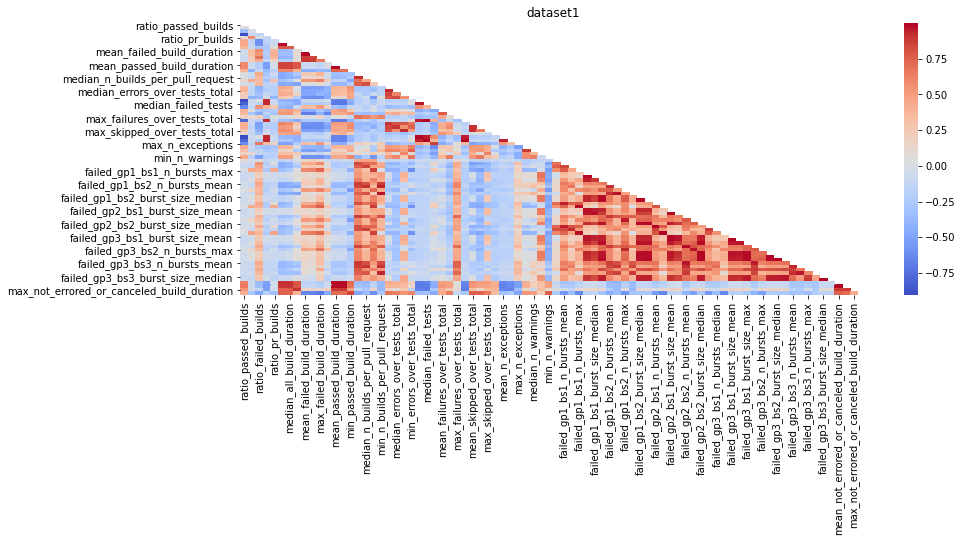

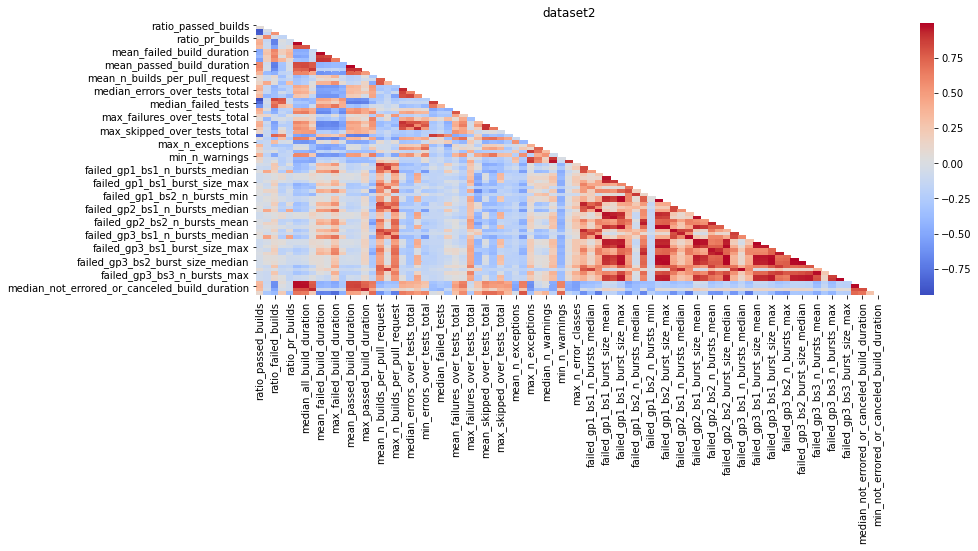

In [368]:
for method in methods:
    matrix = np.triu(methods_indep_var[method].corr())
    ax = sns.heatmap(methods_indep_var[method].corr(), cmap= 'coolwarm', mask=matrix)
    ax.set_title(method)
    plt.show()

**Do datasets have same columns?**

In [369]:
set(methods_indep_var[methods[0]]).difference(set(methods_indep_var[methods[1]]))

{'failed_gp3_bs3_n_bursts_min', 'min_n_builds_per_pull_request'}

In [370]:
set(methods_indep_var[methods[1]]).difference(set(methods_indep_var[methods[0]]))

{'failed_gp2_bs1_n_bursts_median',
 'max_passed_build_duration',
 'mean_n_error_classes'}

### Normal distribution

In [371]:
method_normal_distributed_features = {}
for method in methods:
    shapiro_feat = methods_indep_var[method].apply(lambda x: shapiro(x)).T
    shapiro_feat.columns = ["statistic", "pval"]
    normal_feat = methods_indep_var[method].apply(lambda x: normaltest(x)).T
    normal_feat.columns = ["statistic", "pval"]
    method_normal_distributed_features[method] = list(shapiro_feat[shapiro_feat.pval > 0.05].index)\
    + list(normal_feat[normal_feat.pval > 0.05].index)

<AxesSubplot:ylabel='Frequency'>

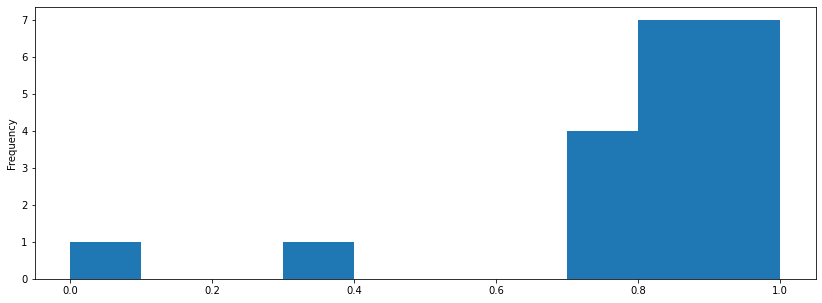

In [372]:
methods_indep_var[methods[0]].ratio_passed_builds.plot(kind="hist")

<Figure size 1008x360 with 0 Axes>

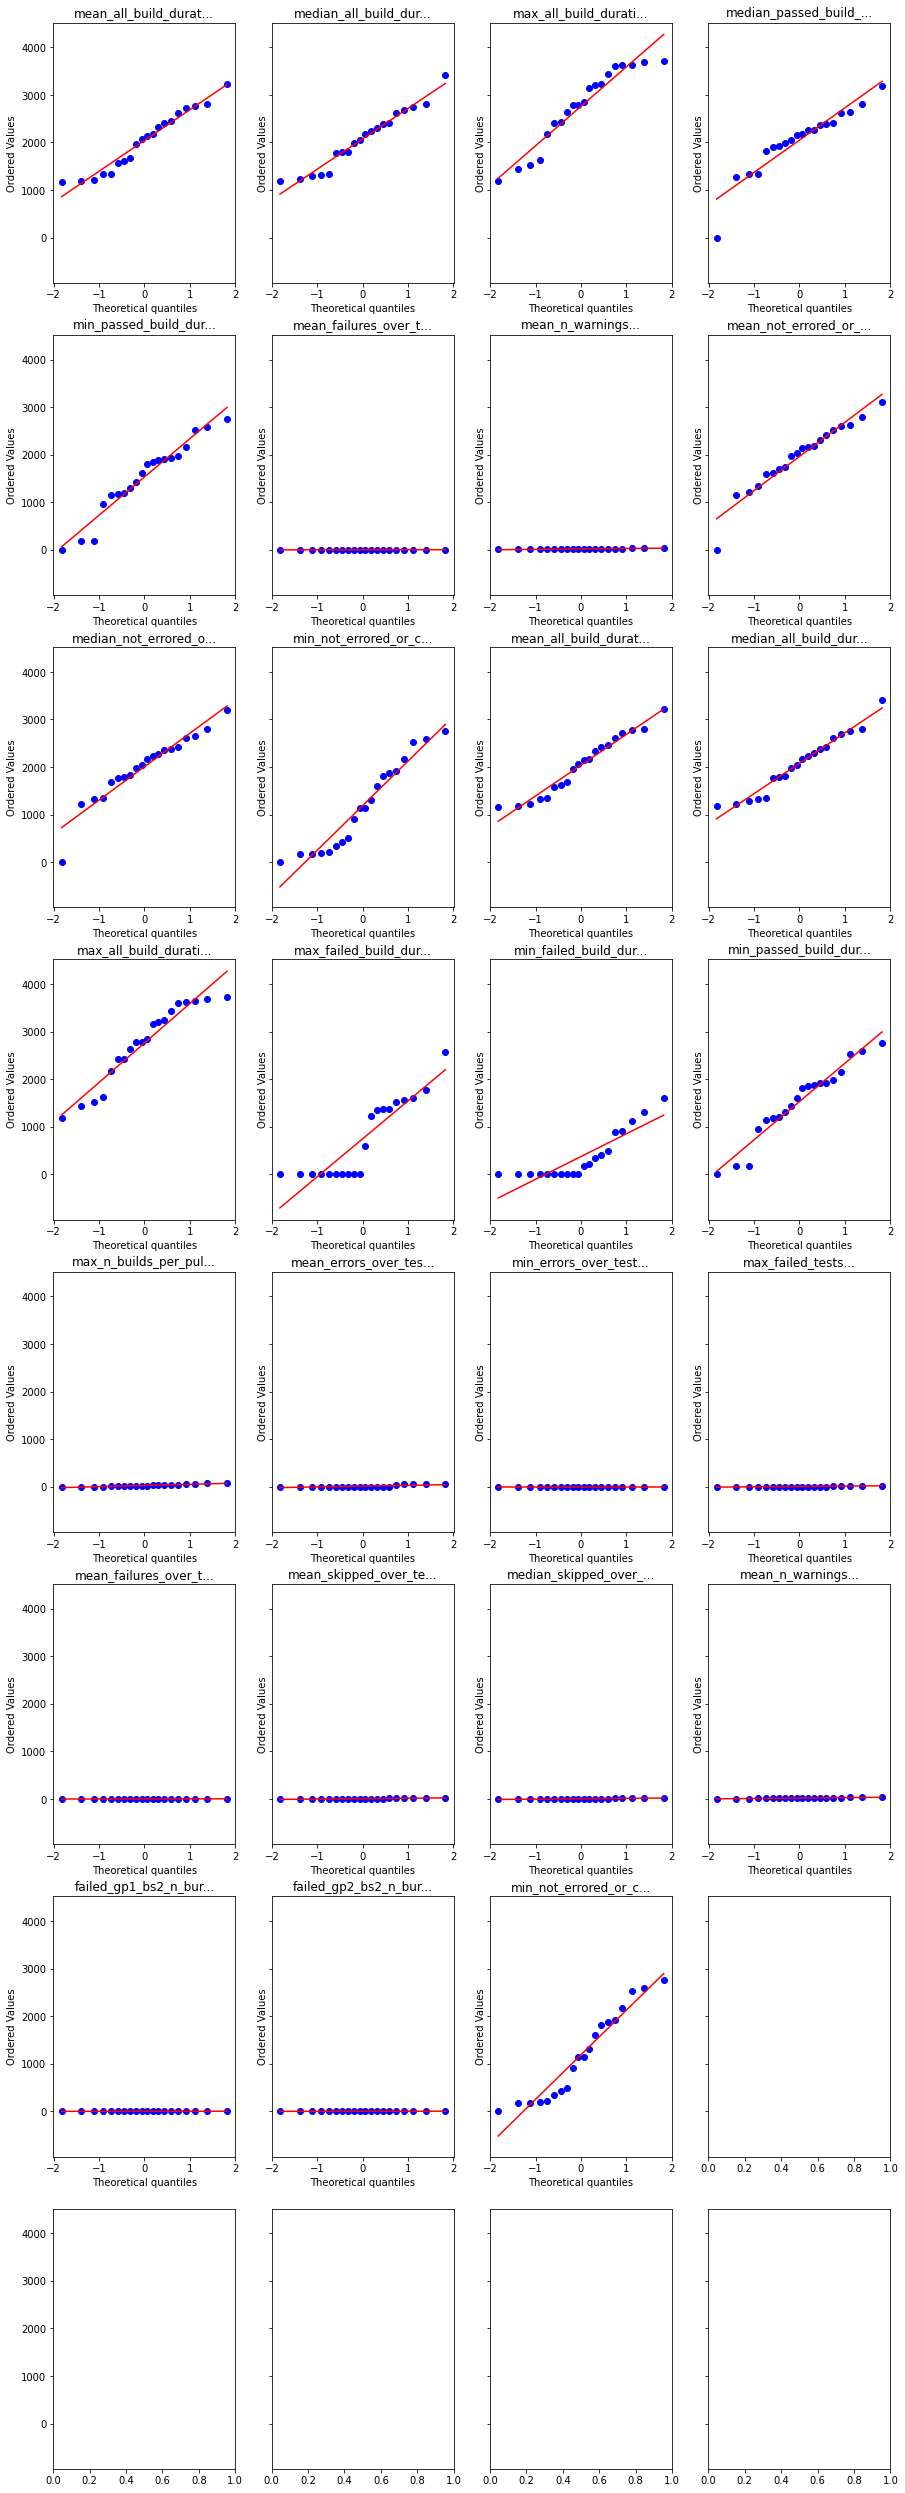

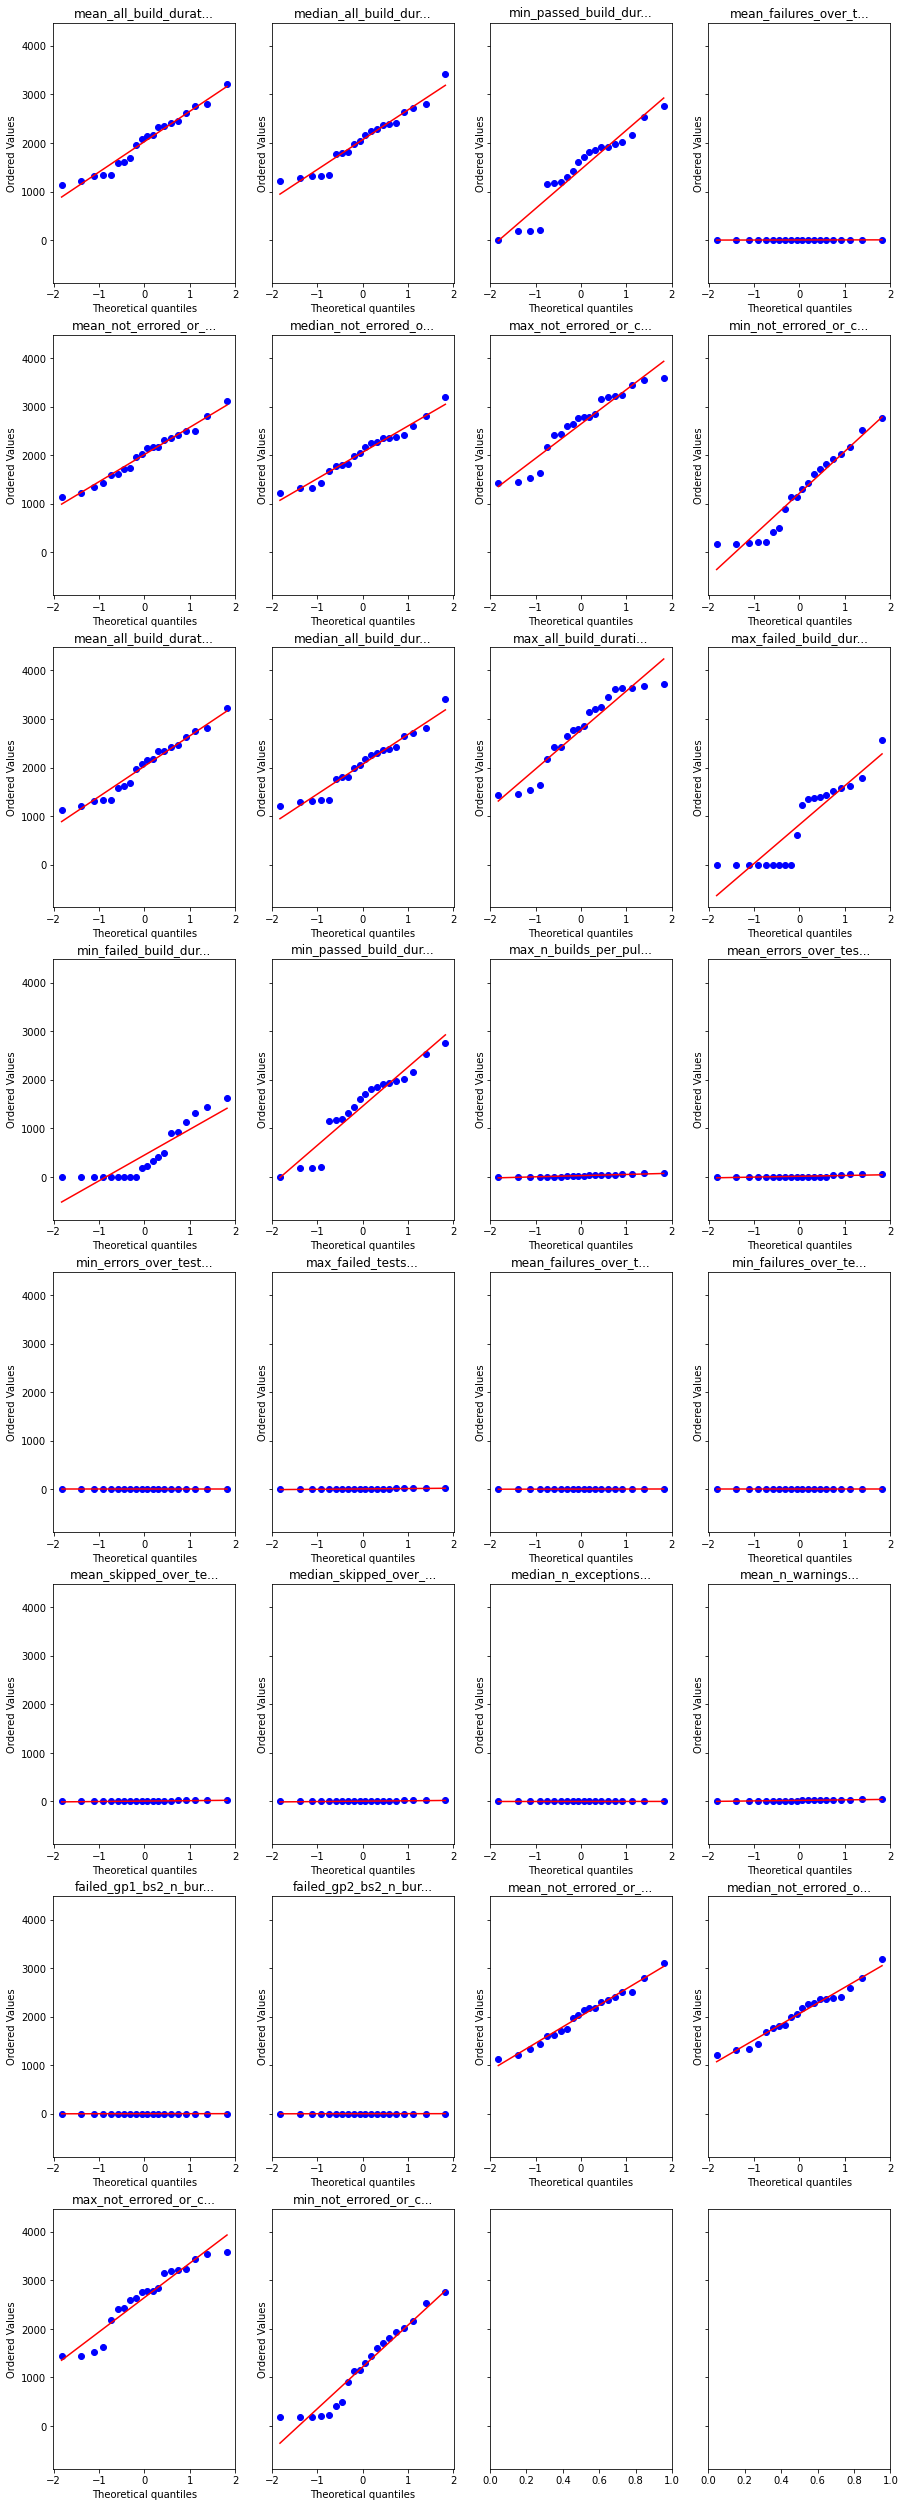

In [373]:
plt.figure()
normal_features = {}
for method in methods:
    df = methods_indep_var[method]
    normal_features[method] = method_normal_distributed_features[method]
    if(len(normal_features) < 1):
        continue
    fig, axes = plt.subplots(nrows=8, ncols=int(len(normal_features[method])/8)+1, sharey=True, figsize=(15.0, 45.0))
    axes = axes.flatten()
    for i, feat in enumerate(normal_features[method]):
        scipy.stats.probplot(df[feat], dist="norm", plot=axes[i])
        axes[i].set_title(feat[:20]+"...")
#plt.savefig(f"{figure_folder}/dataset_preprocessing/{mask_name}_qq-plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
#plt.show()

In [374]:
for method in methods:
    x = normal_features[method]
    print(method, len(x))

dataset1 27
dataset2 30


((array([-1.8241636 , -1.38768012, -1.11829229, -0.91222575, -0.73908135,
         -0.5857176 , -0.44506467, -0.31273668, -0.18568928, -0.06158146,
          0.06158146,  0.18568928,  0.31273668,  0.44506467,  0.5857176 ,
          0.73908135,  0.91222575,  1.11829229,  1.38768012,  1.8241636 ]),
  array([ 0.,  0.,  1.,  1.,  2.,  2.,  5.,  6.,  6.,  7.,  7.,  9.,  9.,
         10., 16., 18., 18., 18., 22., 23.])),
 (7.637746112583419, 8.999999999999998, 0.9580499420514086))

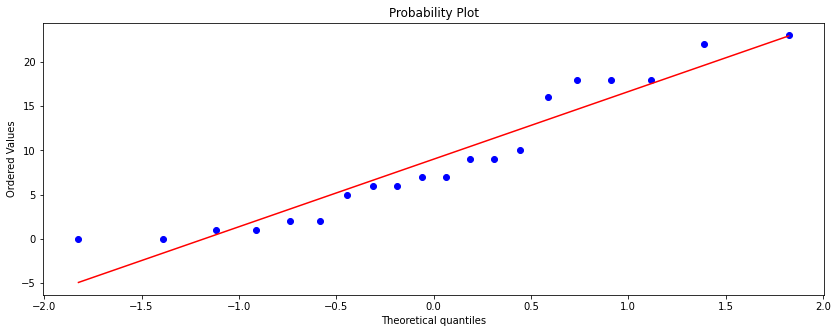

In [375]:
scipy.stats.probplot(methods_dep_var[method].post_release_bugs, dist="norm", plot=plt)

In [376]:
for method in methods:
    print(normaltest(methods_dep_var[method].post_release_bugs))

NormaltestResult(statistic=2.8352907608258793, pvalue=0.24228383204137358)
NormaltestResult(statistic=2.8352907608258793, pvalue=0.24228383204137358)


A visual test does not seem to confirm that these features are indeed normally distributed. We conclude that none of our features are normally distributed.

### Correlated features

<Figure size 1008x360 with 0 Axes>

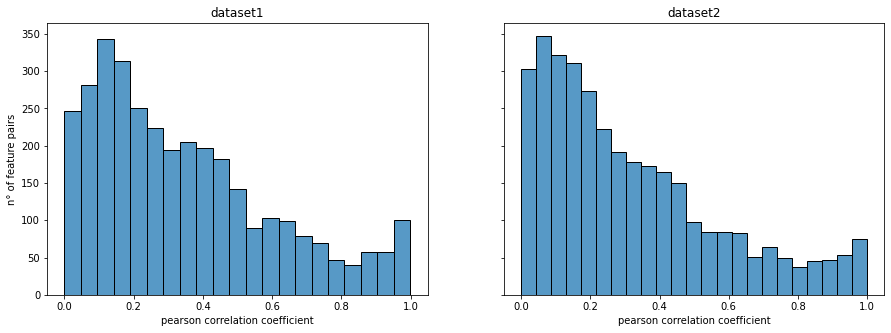

In [377]:
plt.figure()
methods_correlated_features = {}
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15.0, 5.0))
for i, method in enumerate(methods):
    corr_matrix = methods_indep_var[method].corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False)).round(decimals = 3)
    methods_correlated_features[method] = sol[sol > 0.8]
    ax = sns.histplot(sol, ax=axes[i])
    ax.set_title(method)
    ax.set(xlabel="pearson correlation coefficient",ylabel="n° of feature pairs")
plt.savefig(f"{figure_folder}/dataset_preprocessing/{mask_name}_correlated_feature_dist.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [378]:
methods_correlated_features[methods[1]].head(10)

failed_gp3_bs1_burst_size_mean    failed_gp3_bs1_burst_size_median    0.999
failed_gp2_bs2_burst_size_median  failed_gp3_bs2_burst_size_median    0.999
failed_gp3_bs3_burst_size_median  failed_gp3_bs3_burst_size_max       0.999
failed_gp2_bs2_burst_size_median  failed_gp3_bs2_burst_size_max       0.999
failed_gp1_bs2_burst_size_median  failed_gp1_bs2_burst_size_max       0.999
failed_gp3_bs2_burst_size_mean    failed_gp3_bs2_burst_size_median    0.998
failed_gp3_bs2_burst_size_median  failed_gp3_bs2_burst_size_max       0.997
failed_gp2_bs2_burst_size_median  failed_gp3_bs2_burst_size_mean      0.995
failed_gp2_bs1_n_bursts_max       failed_gp3_bs1_n_bursts_max         0.994
mean_passed_build_duration        median_passed_build_duration        0.994
dtype: float64

In [379]:
methods_correlated_features[methods[0]].head(10)

failed_gp3_bs1_burst_size_mean    failed_gp3_bs1_burst_size_median    0.999
failed_gp2_bs2_burst_size_median  failed_gp3_bs2_burst_size_median    0.999
failed_gp3_bs3_burst_size_median  failed_gp3_bs3_burst_size_max       0.999
failed_gp2_bs2_burst_size_median  failed_gp3_bs2_burst_size_max       0.999
failed_gp1_bs2_burst_size_median  failed_gp1_bs2_burst_size_max       0.999
failed_gp3_bs2_burst_size_mean    failed_gp3_bs2_burst_size_median    0.998
failed_gp2_bs1_burst_size_mean    failed_gp3_bs1_burst_size_mean      0.998
mean_failed_tests                 mean_n_exceptions                   0.998
failed_gp2_bs1_burst_size_mean    failed_gp3_bs1_burst_size_median    0.997
failed_gp3_bs2_burst_size_median  failed_gp3_bs2_burst_size_max       0.997
dtype: float64

### Correlation with dependent variable
https://dataschool.com/fundamentals-of-analysis/correlation-and-p-value/

We proceed with analysing the correlation of our attributed with the three software quality metricsm
We calculate both types of correlation:
* Pearons (linear)
* Spearman (monotonic, is pearson applied to ranks)

https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/#:~:text=The%20Pearson%20correlation%20evaluates%20the%20linear%20relationship%20between%20two%20continuous%20variables.&text=The%20Spearman%20correlation%20coefficient%20is,evaluate%20relationships%20involving%20ordinal%20variables.

In [380]:
methods_pearson_corr_post_release_bugs = {}
methods_spearman_corr_post_release_bugs = {}
for method in methods:
    data = []
    corr_col = methods_dep_var[method].post_release_bugs
    x = methods_indep_var[method][normal_features[method]].apply(lambda x:\
                                scipy.stats.pearsonr(x, corr_col)).T
    x.columns = ["pearson_corr", "pval"]
    methods_pearson_corr_post_release_bugs[method] = x

    x = methods_indep_var[method].drop(normal_features[method], axis=1).apply(lambda x:\
                                scipy.stats.spearmanr(x, corr_col)).T
    x.columns = ["spearman_corr", "pval"]
    methods_spearman_corr_post_release_bugs[method] = x

**Feature category correlation per each dataset**

In [381]:
feature_categories = ["ratio_(.*)_builds",
                     "(.*)_(.*)_build_duration",
                     "(.*)_n_builds_per_pull_request",
                     "(.*)_errors_over_tests_total",
                     "(.*)_failed_tests",
                     "(.*)_failures_over_tests_total",
                     "(.*)_skipped_over_tests_total",
                     "(.*)_n_exceptions",
                     "(.*)_n_warnings",
                     "(.*)_n_error_classes",
                     #"(.*)_burst_size",
                     "(.*)burst"]

In [382]:
linearly_corr_features = {}
for method in methods:
    x = methods_pearson_corr_post_release_bugs[method]
    linearly_corr_features[method] = x[x.pval < 0.05].index
    x["abs"] = x.pearson_corr.abs()
    print(x[x.pval < 0.05].sort_values(by="abs",ascending=False)[["pearson_corr"]].round(2).to_latex())

\begin{tabular}{lr}
\toprule
{} &  pearson\_corr \\
\midrule
median\_all\_build\_duration                     &         -0.82 \\
median\_all\_build\_duration                     &         -0.82 \\
median\_not\_errored\_or\_canceled\_build\_duration &         -0.81 \\
mean\_all\_build\_duration                       &         -0.80 \\
mean\_all\_build\_duration                       &         -0.80 \\
mean\_not\_errored\_or\_canceled\_build\_duration   &         -0.79 \\
median\_passed\_build\_duration                  &         -0.78 \\
max\_all\_build\_duration                        &         -0.74 \\
max\_all\_build\_duration                        &         -0.74 \\
mean\_failures\_over\_tests\_total                &         -0.62 \\
mean\_failures\_over\_tests\_total                &         -0.62 \\
min\_not\_errored\_or\_canceled\_build\_duration    &         -0.57 \\
min\_not\_errored\_or\_canceled\_build\_duration    &         -0.57 \\
mean\_skipped\_over\_tests\_total        

In [383]:
for method in methods:
    x = methods_spearman_corr_post_release_bugs[method]
    x["abs"] = x.spearman_corr.abs()
    print(x[x.pval < 0.05].sort_values(by="abs",ascending=False)[["spearman_corr"]].round(2).to_latex())

\begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
max\_not\_errored\_or\_canceled\_build\_duration &          -0.68 \\
mean\_passed\_build\_duration                 &          -0.66 \\
max\_skipped\_over\_tests\_total               &          -0.64 \\
min\_skipped\_over\_tests\_total               &          -0.61 \\
min\_n\_builds\_per\_pull\_request              &           0.52 \\
median\_failures\_over\_tests\_total           &          -0.47 \\
ratio\_failed\_builds                        &           0.45 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
median\_passed\_build\_duration     &          -0.72 \\
mean\_passed\_build\_duration       &          -0.69 \\
max\_passed\_build\_duration        &          -0.68 \\
ratio\_failed\_builds              &           0.65 \\
max\_skipped\_over\_tests\_total     &          -0.64 \\
min\_skipped\_over\_tests\_total     &          -0.60 \\
median\_failures\_over\_tests\_total &     

In [384]:
import re
for cat in feature_categories:
    print("-"*10)
    print(cat)
    for method in methods:
        x = methods_spearman_corr_post_release_bugs[method]
        x = x[x.pval < 0.05].round(2)
        print(method, "\n", x[[True if re.search(cat, s) else False for s in x.index]]\
              .spearman_corr.sort_values(ascending=False).to_latex())

----------
ratio_(.*)_builds
dataset1 
 \begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
ratio\_failed\_builds &           0.45 \\
\bottomrule
\end{tabular}

dataset2 
 \begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
ratio\_failed\_builds &           0.65 \\
\bottomrule
\end{tabular}

----------
(.*)_(.*)_build_duration
dataset1 
 \begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
mean\_passed\_build\_duration                 &          -0.66 \\
max\_not\_errored\_or\_canceled\_build\_duration &          -0.68 \\
\bottomrule
\end{tabular}

dataset2 
 \begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
mean\_failed\_build\_duration   &           0.45 \\
max\_passed\_build\_duration    &          -0.68 \\
mean\_passed\_build\_duration   &          -0.69 \\
median\_passed\_build\_duration &          -0.72 \\
\bottomrule
\end{tabular}

----------
(.*)_n_builds_per_pull_request
dataset1 
 \begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\m

In [385]:
corr = methods_spearman_corr_post_release_bugs[methods[1]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
spearman_corr

median_passed_build_duration       -0.721515
mean_passed_build_duration         -0.692835
max_passed_build_duration          -0.678495
ratio_failed_builds                 0.654374
max_skipped_over_tests_total       -0.636126
min_skipped_over_tests_total       -0.601791
median_failures_over_tests_total   -0.567551
min_n_warnings                     -0.511722
median_errors_over_tests_total     -0.489999
max_n_exceptions                    0.479900
mean_failed_build_duration          0.448646
Name: spearman_corr, dtype: float64

In [386]:
spearman_corr[[col for col in spearman_corr.index if re.search("(.*)_(.*)_build_duration", col)]]

median_passed_build_duration   -0.721515
mean_passed_build_duration     -0.692835
max_passed_build_duration      -0.678495
mean_failed_build_duration      0.448646
Name: spearman_corr, dtype: float64

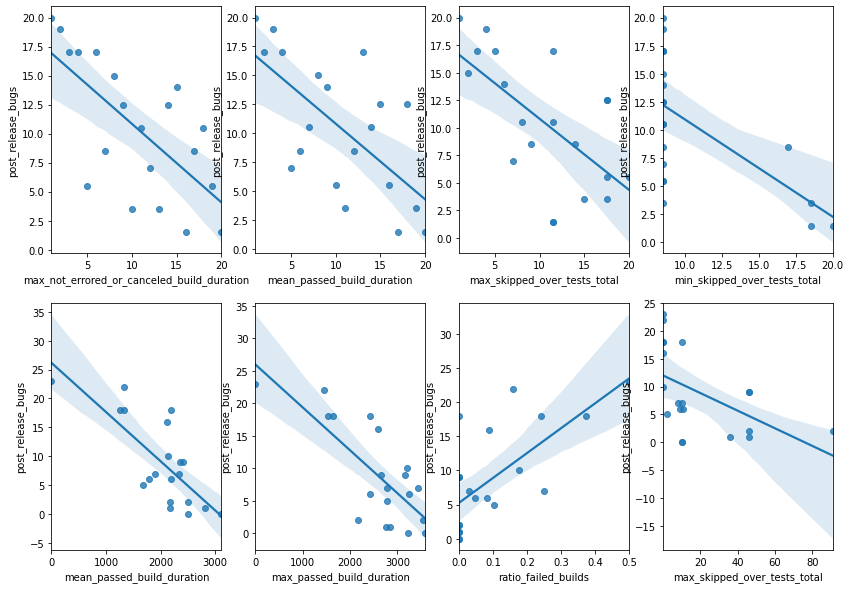

In [387]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14.0, 10.0))
axes = axes.flatten()

corr = methods_spearman_corr_post_release_bugs[methods[0]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
for i in range(4):
    feature = spearman_corr.index[i]
    sns.regplot(x=methods_indep_var[methods[0]][feature].rank(),
                   y=methods_dep_var[methods[0]].post_release_bugs.rank(), ax=axes[i])
    
corr = methods_spearman_corr_post_release_bugs[methods[1]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
for j in range(i+1, 8):
    feature = spearman_corr.index[j-i]
    sns.regplot(x=methods_indep_var[methods[1]][feature],
                   y=methods_dep_var[methods[1]].post_release_bugs, ax=axes[j])

df = methods_spearman_corr_post_release_bugs[methods[0]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
ax = df[[col for col in df.index if not "burst" in col]].head(20).plot(kind="bar")
ax.set_title("Top 20 spearman rank correlations with post release bugs (no burst metrics)")

(0.4504268030899486, 0.04626350948986403)


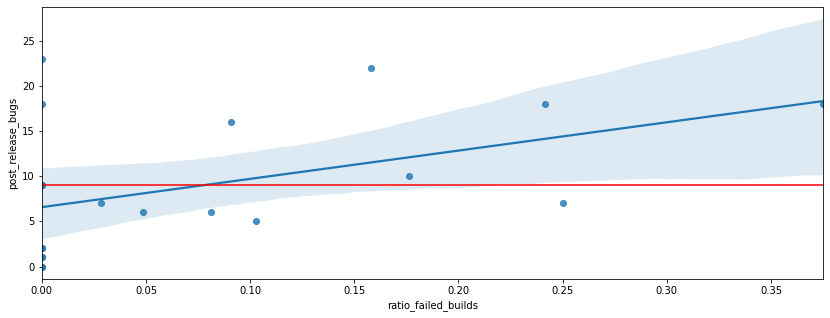

In [388]:
df_ind = methods_indep_var[methods[0]]
df_dep = methods_dep_var[methods[0]]
x = df_ind.ratio_failed_builds
y = df_dep.post_release_bugs
print(scipy.stats.pearsonr(x,y))
ax = sns.regplot(x=x, y=y)
ax.axhline(y=df_dep.post_release_bugs.mean(), color="r")

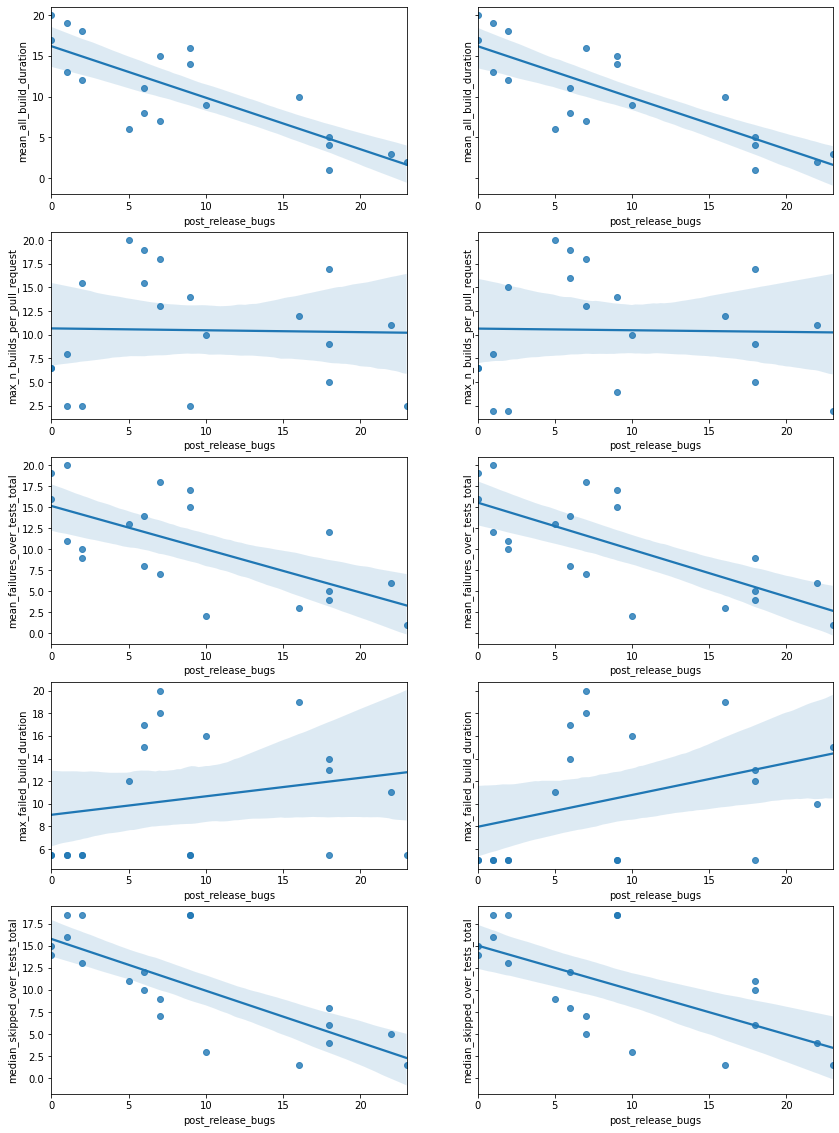

In [389]:
columns = ["mean_all_build_duration", "max_n_builds_per_pull_request",\
          "mean_failures_over_tests_total", "max_failed_build_duration", "median_skipped_over_tests_total"]
fig, axes = plt.subplots(nrows=len(columns), ncols=2, sharey='row', figsize=(14.0, 4*len(columns)))
axes = axes.flatten()
i = 0
for col in columns:
    df_ind = methods_indep_var[methods[0]]
    df_dep = methods_dep_var[methods[0]]
    sns.regplot(y=df_ind[col].rank(), x=df_dep.post_release_bugs, ax=axes[i])
    i+=1
    df_ind = methods_indep_var[methods[1]]
    df_dep = methods_dep_var[methods[1]]
    sns.regplot(y=df_ind[col].rank(), x=df_dep.post_release_bugs, ax=axes[i])
    i+=1

In [390]:
corr = methods_spearman_corr_post_release_bugs[methods[1]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
spearman_corr[spearman_corr.abs() > 0.35].index

Index(['median_passed_build_duration', 'mean_passed_build_duration',
       'max_passed_build_duration', 'ratio_failed_builds',
       'max_skipped_over_tests_total', 'min_skipped_over_tests_total',
       'median_failures_over_tests_total', 'min_n_warnings',
       'median_errors_over_tests_total', 'max_n_exceptions',
       'mean_failed_build_duration'],
      dtype='object')

cols = ['max_failed_tests', 'max_n_builds_per_pull_request',
       'mean_failed_tests', 'failed_gp3_bs1_n_bursts_max',
       'failed_gp3_bs3_burst_size_max', 'max_failed_build_duration',
       'max_n_error_classes', 'median_skipped_over_tests_total',
       'failed_gp1_bs1_burst_size_mean', 'max_n_exceptions',
       'ratio_passed_builds','mean_n_builds_per_pull_request',
        'min_skipped_over_tests_total', 'max_failures_over_tests_total']
df = methods_indep_var[methods[1]][cols].corr(method="spearman")
cols = []
matrix = np.triu(df) 
ax = sns.heatmap(df, cmap= 'coolwarm', mask=matrix, annot=True) 
#ax.set_title(method) 
plt.show()

<AxesSubplot:>

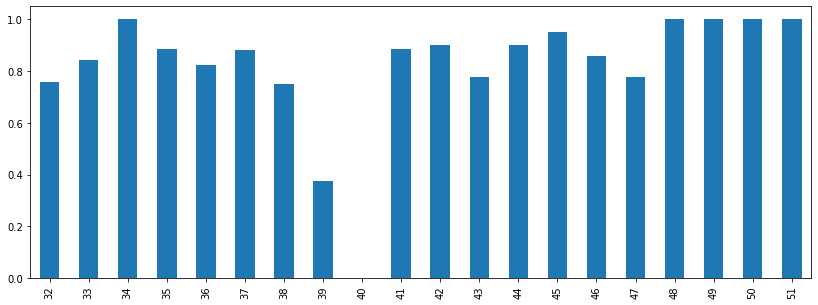

In [391]:
methods_indep_var[methods[1]].ratio_passed_builds.plot(kind="bar")

In [392]:
methods_dep_var[methods[1]].post_release_bugs.describe()

count    20.000000
mean      9.000000
std       7.567242
min       0.000000
25%       2.000000
50%       7.000000
75%      16.500000
max      23.000000
Name: post_release_bugs, dtype: float64

<AxesSubplot:>

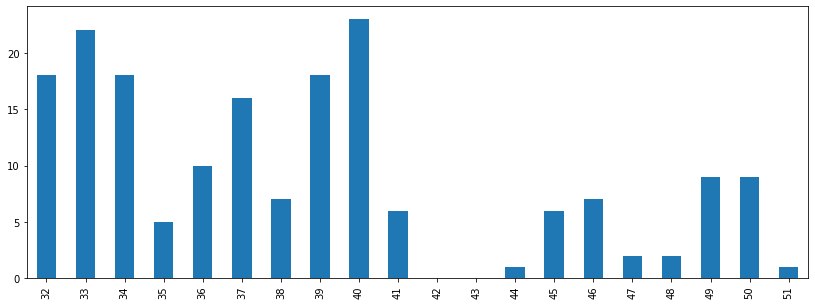

In [393]:
methods_dep_var[methods[1]].post_release_bugs.plot(kind="bar")

<AxesSubplot:>

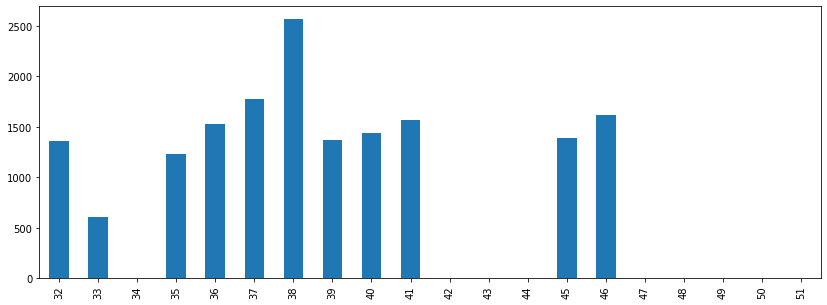

In [394]:
methods_indep_var[methods[1]].max_failed_build_duration.plot(kind="bar")

In [395]:
methods_indep_var[methods[1]].max_failed_build_duration.corr(\
                        methods_indep_var[methods[1]].min_not_errored_or_canceled_build_duration, method="spearman")

-0.7851286633145668

In [396]:
tags = tags[tags.jira_version.isin(direct_and_pr.to_tag)].reset_index(drop=True)
tags_gradle = tags[(tags.year>2018) & (tags.month>3)]
tags_gradle

,actual_release_date,Tag,Sha,Date,month,year,major_version,jira_version
29,NaN,6.7.7,4aa6d928f960303eb990d50c275513a517c85e69,2019-04-16 15:38:04,4,2019,6,6.7.7
38,2019-06-19 00:00:00,7.8,870ae4efbf5dcdbe59295eb5827b55a6a74c7b89,2019-06-18 09:08:04,6,2019,7,7.8
39,2019-07-01 00:00:00,7.9,6502ec4ffee7e5a57498baaf330b80eb490d01c2,2019-07-01 07:56:26,7,2019,7,7.9
40,NaN,7.9.1,6818fad17ba67e97d395a8488d5412e00892d5e1,2019-07-10 12:20:33,7,2019,7,7.9.1
41,NaN,7.9.2,5832fefc31f5ba25f15b3fa66ed816f7b87fd835,2019-12-09 13:03:50,12,2019,7,7.9.2
43,NaN,7.9.4,2f8d99a55899105cbf3e3170194c614c2a6ea4d7,2020-07-23 14:40:10,7,2020,7,7.9.4
44,2019-10-16 00:00:00,8.0,87ca68d63f4afd37d74b2f454430dfde9e862c6a,2019-10-15 08:15:12,10,2019,8,8.0
45,2019-12-16 00:00:00,8.1.0.31237,65a7a7c34de5bff9aed7c3e58eb6dcc87ae34b57,2019-12-17 12:29:34,12,2019,8,8.1
47,2020-04-30 00:00:00,8.3.0.34182,9c58e36328ae79ad3c36c13aa253879351ce3613,2020-04-28 13:54:13,4,2020,8,8.3
48,NaN,8.3.1.34397,b77ce511a2039330aea8832ad12e86a8cfa9ff7d,2020-05-07 12:09:22,5,2020,8,8.3.1


**Remove highly correlated features?**

In [397]:
methods_corr_cols_to_remove = {}
for method in methods:
    cols_to_remove = set()
    print(method, len(methods_correlated_features[method]))
    corr_matrix = methods_indep_var[method].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    methods_corr_cols_to_remove[method] = [column for column in upper.columns if any(upper[column] > 0.95)]

dataset1 261
dataset2 242


In [398]:
for method in methods:
    cols_to_remove = methods_corr_cols_to_remove[method]
    methods_indep_var[method] = methods_indep_var[method].drop(columns=cols_to_remove, errors="ignore")
    print(methods_indep_var[method].shape)

(20, 48)
(20, 55)


for method in methods:
    matrix = np.triu(methods_indep_var[method].corr())
    ax = sns.heatmap(methods_indep_var[method].corr(), cmap= 'coolwarm', mask=matrix)
    ax.set_title(method)
    plt.show()

### Play with feature selection

In [399]:
# example of correlation feature selection for numerical data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, RFECV
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.dummy import DummyRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, precision_score, make_scorer
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

In [400]:
regression_mask = mask_to_use
cross_validation_strategy = KFold(3, shuffle=True, random_state=1)

In [401]:
method_x_train = {}
method_y_train = {}
method_train_columns = {}
for method in methods:
    X_train = methods_indep_var[method][regression_mask]
    y_train = methods_dep_var[method].post_release_bugs[regression_mask]
    train_columns = X_train.columns
    X_train[X_train.columns] = StandardScaler().fit_transform(X_train)
    method_x_train[method] = X_train
    method_y_train[method] = y_train
    method_train_columns[method] = train_columns

<ipython-input-401-4f638e0bc459>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = methods_indep_var[method][regression_mask]
<ipython-input-401-4f638e0bc459>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = methods_indep_var[method][regression_mask]


In [402]:
def two_layer_cross_validate(model, params_grid, x, y, num_trials, n_splits, scoring=None):
    nested_scores = np.zeros(num_trials)
    for i in range(num_trials):
        inner_cv = KFold(n_splits=n_splits, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=i)

        # Non_nested parameter search and scoring
        clf = GridSearchCV(estimator=model, param_grid=params_grid, cv=inner_cv)
        """clf.fit(method_x_train[methods[1]], method_y_train[methods[1]])
        non_nested_scores[i] = clf.best_score_
        """
        # Nested CV with parameter optimization
        nested_score = cross_val_score(clf, x, y, cv=outer_cv, scoring=scoring)
        nested_scores[i] = nested_score.mean()
    return nested_scores

In [504]:
def two_layer_cross_validate_cv(model, params_grid, x, y, num_trials, cv, scoring=None):
    nested_scores = np.zeros(num_trials)
    for i in range(num_trials):
        inner_cv = cv
        outer_cv = cv

        # Non_nested parameter search and scoring
        clf = GridSearchCV(estimator=model, param_grid=params_grid, cv=inner_cv)
        """clf.fit(method_x_train[methods[1]], method_y_train[methods[1]])
        non_nested_scores[i] = clf.best_score_
        """
        # Nested CV with parameter optimization
        nested_score = cross_val_score(clf, x, y, cv=outer_cv, scoring=scoring)
        nested_scores[i] = nested_score.mean()
    return nested_scores

In [403]:
def outer_layer_cross_validate(model, x, y, num_trials, n_splits, scoring=None):
    nested_scores = np.zeros(num_trials)
    for i in range(num_trials):
        outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=i)
        # Nested CV with parameter optimization
        nested_score = cross_val_score(model, x, y, cv=outer_cv, scoring=scoring)
        nested_scores[i] = nested_score.mean()
    return nested_scores

In [477]:
def forward_feature_selection(model, X, y, cv=5, scoring="r2"):
    best_performance = np.array([-100])
    added_columns = list()
    feature_performance = {}
    feature_performance["All features"] = perf = cross_val_score(model, X,\
                                   y, cv=cv, scoring=scoring)
    while(True):
        #print("Best perf", best_performance)
        current_perf = best_performance
        curr_col = None
        for col in X.columns:
            if col in added_columns:
                continue
            perf = cross_val_score(model, X[set(added_columns).union(set([col]))],\
                                   y, cv=cv, scoring=scoring)
            #print(added_columns.union(set([col])), perf.mean())
            if current_perf.min() < perf.min():
                current_perf = perf
                curr_col = col
        if current_perf.mean() <= best_performance:
            break
        else:
            best_performance = current_perf.min()
            added_columns.append(curr_col)
            feature_performance[curr_col] = current_perf
            #print(added_columns)
    return added_columns, best_performance, feature_performance

**Regression**

In [405]:
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 4)]
min_samples_leaf = [1,2,3,4]
max_depth = [4,8,16,None]
params_grid = {'min_samples_leaf': min_samples_leaf,
               "max_depth" : max_depth
              }

model = DecisionTreeRegressor()
method_randomregressor_r2 = {}
method_randomregressor_neg_mean_error = {}
for method in methods:
    method_randomregressor_r2[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_train[method], 5, 3, "r2")
    method_randomregressor_neg_mean_error[method] = \
        two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_train[method], 5, 3, "neg_mean_absolute_error")

In [406]:
for method in methods:
    print("R2","-"*40)
    print(method, method_randomregressor_r2[method])
    print("Nmae","-"*40)
    print(method, method_randomregressor_neg_mean_error[method])

R2 ----------------------------------------
dataset1 [-0.4029226  -0.01735577  0.06231952  0.25105911 -0.29726772]
Nmae ----------------------------------------
dataset1 [-5.67639834 -5.03968254 -4.59761905 -5.65873016 -6.67577475]
R2 ----------------------------------------
dataset2 [-1.75769798 -0.25810169  0.4444235  -0.15711299 -0.54101495]
Nmae ----------------------------------------
dataset2 [-5.38888889 -5.46296296 -4.45079365 -5.8564059  -7.93650794]


In [407]:
method_knn_regr_features = {}
method_knn_feature_performance = {}
for method in methods:
    features, score, feature_performance = forward_feature_selection(KNeighborsRegressor(), method_x_train[method],\
                                           method_y_train[method], cv=cross_validation_strategy)
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_knn_regr_features[method] = features
    method_knn_feature_performance = feature_performance

--------------------
dataset1 ['max_all_build_duration', 'mean_all_build_duration', 'median_failures_over_tests_total', 'max_n_builds_per_pull_request', 'ratio_canceled_builds'] 0.6131412182158379
--------------------
--------------------
dataset2 ['max_all_build_duration', 'mean_all_build_duration'] 0.46914024664484977
--------------------


<Figure size 1008x360 with 0 Axes>

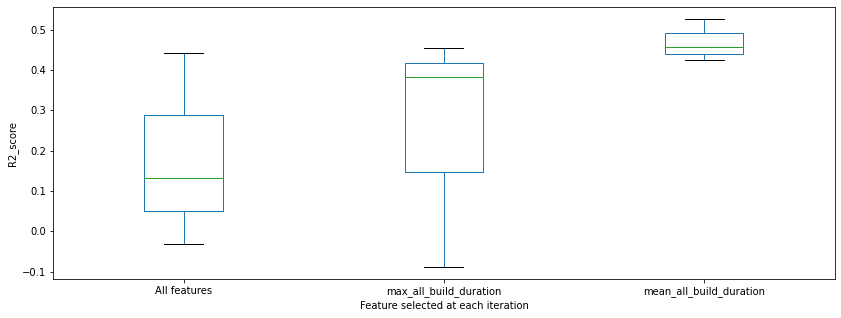

In [408]:
plt.figure()
ax = pd.DataFrame(method_knn_feature_performance).plot(kind="box")
ax.set(ylabel="R2_score", xlabel="Feature selected at each iteration")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/knn_feature_selection_r2.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [409]:
params_grid = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 4, num = 4)],
              'p': [1,2,3]}
model = KNeighborsRegressor()
method_knregressor_r2 = {}
method_knregressor_neg_mean_error = {}
for method in methods:
    x = method_x_train[method][method_knn_regr_features[method]]
    method_knregressor_r2[method] = \
        two_layer_cross_validate(model, params_grid, x, method_y_train[method], 5, 3, "r2")
    method_knregressor_neg_mean_error[method] = \
        two_layer_cross_validate(model, params_grid, x, method_y_train[method], 5, 3, "neg_mean_absolute_error")

In [410]:
for method in methods:
    print(method, method_knregressor_r2[method])
    print(method, method_knregressor_neg_mean_error[method])

dataset1 [0.20362659 0.44203134 0.42709913 0.65099558 0.21067969]
dataset1 [-4.80952381 -4.35449735 -4.24603175 -3.26984127 -4.93849206]
dataset2 [-0.14946414  0.42260883  0.50798589  0.42435948  0.06272078]
dataset2 [-4.89087302 -4.08862434 -4.16137566 -3.79100529 -5.51190476]


In [411]:
"""def forward_cross_validation(model, X, y):
    best_performance = cross_val_score(DummyRegressor(strategy="mean"), X, y, scoring="neg_mean_absolute_error").mean()
    added_columns = set()
    while(True):
        print("Best perf", best_performance)
        current_perf = best_performance
        curr_col = None
        for col in X.columns:
            if col in added_columns:
                continue
            perf = cross_val_score(model, X[added_columns.union(set([col]))], y, scoring="neg_mean_absolute_error")
            print(added_columns.union(set([col])), perf.mean())
            if current_perf < perf.mean():
                current_perf = perf.mean()
                curr_col = col
        print("end cycle", col, current_perf)
        if current_perf <= best_performance:
            break
        else:
            best_performance = current_perf
            added_columns.add(curr_col)
            print(added_columns)
    return added_columns, best_performance"""

'def forward_cross_validation(model, X, y):\n    best_performance = cross_val_score(DummyRegressor(strategy="mean"), X, y, scoring="neg_mean_absolute_error").mean()\n    added_columns = set()\n    while(True):\n        print("Best perf", best_performance)\n        current_perf = best_performance\n        curr_col = None\n        for col in X.columns:\n            if col in added_columns:\n                continue\n            perf = cross_val_score(model, X[added_columns.union(set([col]))], y, scoring="neg_mean_absolute_error")\n            print(added_columns.union(set([col])), perf.mean())\n            if current_perf < perf.mean():\n                current_perf = perf.mean()\n                curr_col = col\n        print("end cycle", col, current_perf)\n        if current_perf <= best_performance:\n            break\n        else:\n            best_performance = current_perf\n            added_columns.add(curr_col)\n            print(added_columns)\n    return added_columns, best_pe

In [412]:
method_lin_regr_features = {}
method_lin_regr_feature_performance = {}
for i, method in enumerate(methods):
    columns = method_x_train[method].columns.intersection(normal_features[method])
    features, score, feature_performance = forward_feature_selection(LinearRegression(), method_x_train[method][columns],\
                                           method_y_train[method], cv=cross_validation_strategy)
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_lin_regr_features[method] = features
    if i == 0:
        method_lin_regr_feature_performance = feature_performance

--------------------
dataset1 ['mean_all_build_duration', 'max_n_builds_per_pull_request'] 0.5443931833671969
--------------------
--------------------
dataset2 ['mean_all_build_duration', 'max_n_builds_per_pull_request', 'mean_failures_over_tests_total', 'median_n_exceptions', 'max_not_errored_or_canceled_build_duration'] 0.5704872715415368
--------------------


<Figure size 1008x360 with 0 Axes>

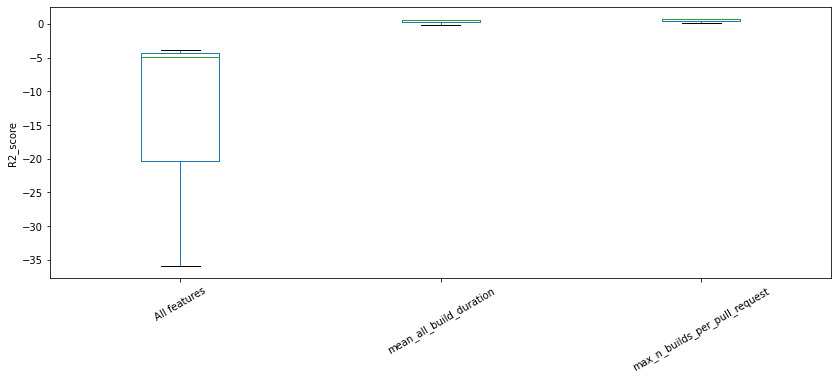

In [413]:
plt.figure()
ax = pd.DataFrame(method_lin_regr_feature_performance).plot(kind="box", showfliers=False)
ax.set(ylabel="R2_score")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/linreg_feature_selection_r2.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [414]:
method_linregression_r2 = {}
method_linregression_nmae = {}
for method in methods:
    features = method_lin_regr_features[method]
    method_linregression_r2[method] = outer_layer_cross_validate(LinearRegression(), method_x_train[method][features],\
                    method_y_train[method], 5, 3, scoring="r2")
    method_linregression_nmae[method] = outer_layer_cross_validate(LinearRegression(), method_x_train[method][features],\
                    method_y_train[method], 5, 3, scoring="neg_mean_absolute_error")

In [415]:
for method in methods:
    print("R2","-"*40)
    print(method, method_linregression_r2[method])
    print(method_linregression_r2[method].mean())
    print("Nmae","-"*40)
    print(method, method_linregression_nmae[method])

R2 ----------------------------------------
dataset1 [0.52342497 0.54439318 0.58631971 0.63428635 0.43207633]
0.5441001092760611
Nmae ----------------------------------------
dataset1 [-3.43092211 -3.75285579 -3.50480468 -3.53425954 -3.82845578]
R2 ----------------------------------------
dataset2 [0.53143659 0.57048727 0.54432517 0.54663562 0.45103738]
0.5287844058893432
Nmae ----------------------------------------
dataset2 [-3.69005118 -3.62597702 -3.40550117 -4.01310793 -3.63929724]


is_small = y_train < y_train.quantile(.25)
is_large = y_train > y_train.quantile(.75)
is_medium = ~(is_small | is_large)

y_quantiles = y_train.mask(is_small, 'small').mask(is_large, 'large').mask(is_medium, 'medium')

<Figure size 1008x360 with 0 Axes>

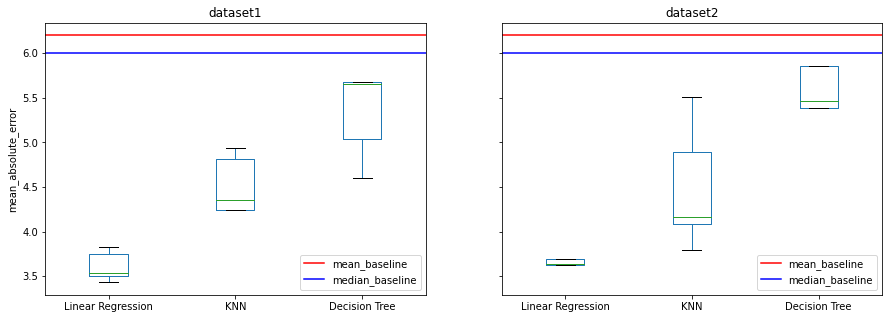

In [416]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"Linear Regression":method_linregression_nmae,
          "KNN": method_knregressor_neg_mean_error,
          "Decision Tree": method_randomregressor_neg_mean_error
         }
for i, method in enumerate(methods):
    data = {}
    for model, score in scores.items():
        data[model] = -score[method]
    ax = pd.DataFrame(data).plot(kind="box", showfliers=False, ax=axes[i])
    x = method_x_train[method]
    y = method_y_train[method]
    ax.axhline(y=mean_absolute_error(DummyRegressor(strategy="mean").fit(x, y).predict(y), y),color='r', label="mean_baseline")
    ax.axhline(y=mean_absolute_error(DummyRegressor(strategy="median").fit(x, y).predict(y), y),color='b', label="median_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="mean_absolute_error")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/regression_neg_mean_absolute_error.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

<Figure size 1008x360 with 0 Axes>

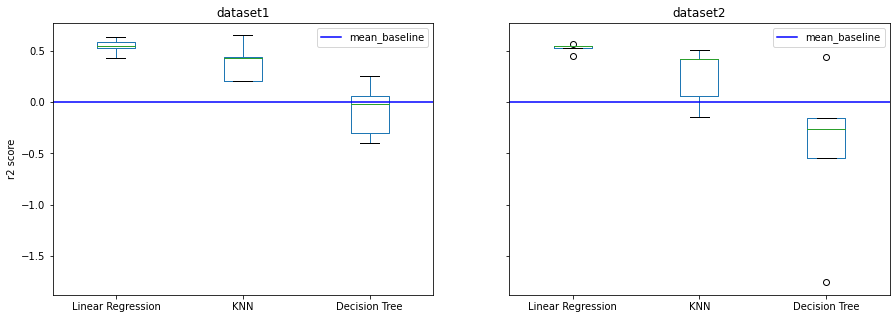

In [417]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"Linear Regression":method_linregression_r2,
          "KNN": method_knregressor_r2, 
          "Decision Tree": method_randomregressor_r2
         }
for i, method in enumerate(methods):
    data = {}
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    y = method_y_train[method]
    #ax.axhline(y=r2_score(DummyRegressor(strategy="mean").fit(x, y).predict(y), y),color='r', label="mean_baseline")
    ax.axhline(y=r2_score(DummyRegressor(strategy="median").fit(x, y).predict(y), y),color='b', label="mean_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="r2 score")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/regression_r2.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

**Linear Regression analysis**

In [418]:
m = methods[1]
method_name = "1"

In [419]:
x = methods_indep_var[m][method_lin_regr_features[m]]
y = methods_dep_var[m].post_release_bugs
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True, random_state=42)
model = LinearRegression().fit(x,y)

In [420]:
tmp = x.copy()
tmp["predicted"] = model.predict(x)
tmp["true"] = y
tmp

,mean_all_build_duration,max_n_builds_per_pull_request,mean_failures_over_tests_total,median_n_exceptions,max_not_errored_or_canceled_build_duration,predicted,true
32,1134.112903,58,1.503639,0.0,1636.0,16.880877,18.0
33,1213.315789,19,1.580081,0.0,1447.0,18.223421,22.0
34,1336.250000,11,1.840264,0.0,1529.0,16.899251,18.0
35,1577.910256,77,2.029270,0.0,2789.0,9.615512,5.0
36,1963.529412,16,0.594383,0.0,3202.0,12.304650,10.0
37,2073.058824,31,0.750895,0.0,2594.0,11.057643,16.0
38,1617.812500,62,3.599441,0.0,2779.0,6.377392,7.0
39,1337.375000,5,1.192779,0.0,2419.0,17.582792,18.0
40,1311.000000,1,0.264326,0.5,1435.0,22.282311,23.0
41,1681.383721,72,2.402805,0.0,2429.0,8.592487,6.0


In [421]:
residuals = y - model.predict(x)

<AxesSubplot:ylabel='Frequency'>

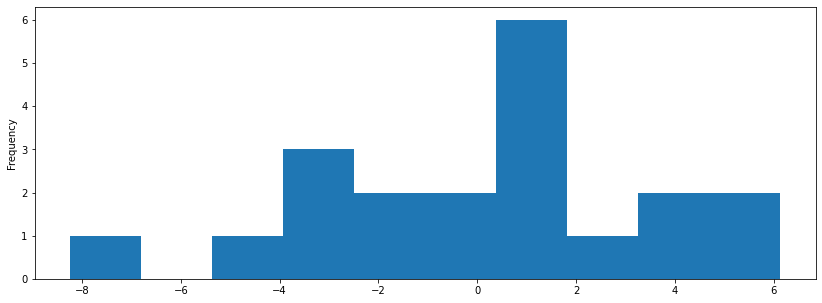

In [422]:
residuals.plot(kind="hist")

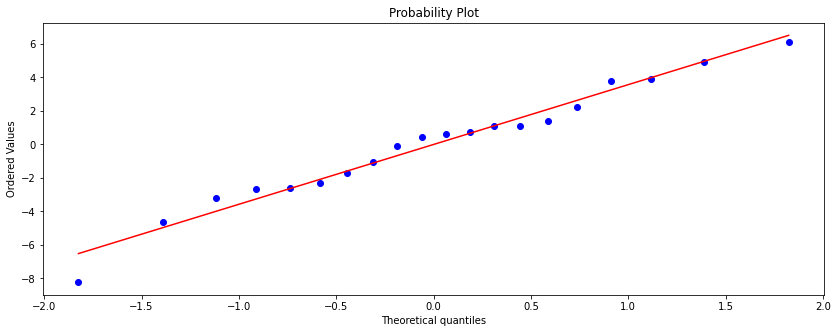

In [423]:
plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/qqplot_residuals{method_name}.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

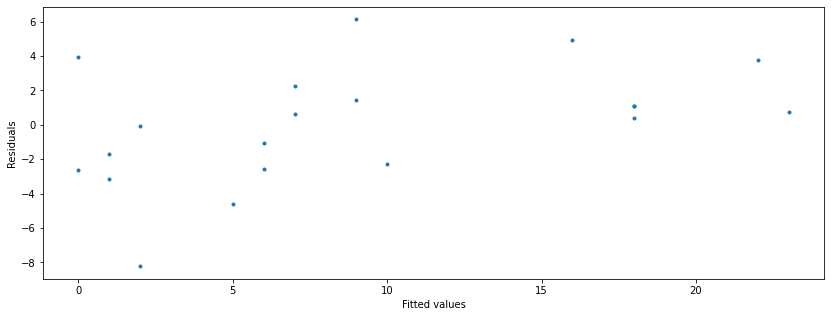

In [424]:
plt.figure()
plt.plot(y,residuals,'.')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/fitted_vs_predicted_residuals{method_name}.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

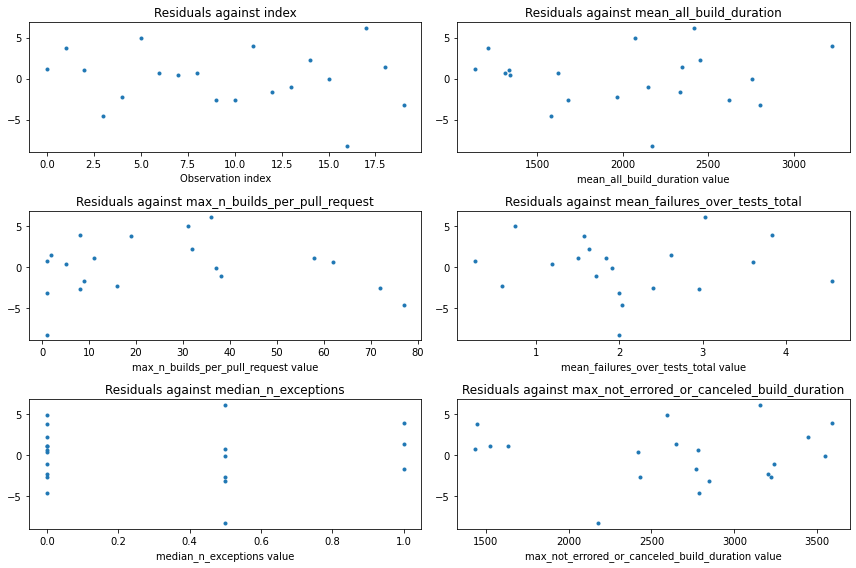

In [425]:
fig = plt.figure(figsize=(12,8))
i = 0

fig.add_subplot(3, 2, i+1)
i+=1
plt.plot(residuals.values,'.')
plt.title("Residuals against index")
plt.xlabel("Residual value")
plt.xlabel("Observation index")
plt.subplots_adjust(wspace=0.4)

for col in method_lin_regr_features[m]:
    fig.add_subplot(3, 2, i+1)
    i+=1
    plt.plot(x[col],residuals,'.')
    plt.title("Residuals against " +str(col))
    plt.xlabel("Residual value")
    plt.xlabel(str(col)+" value")
    plt.subplots_adjust(wspace=0.4)
    plt.tight_layout()
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/indep_residuals{method_name}.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

In [426]:
model.intercept_

34.64589389894957

In [427]:
pd.Series(model.coef_, x.columns)

mean_all_build_duration                      -0.008220
max_n_builds_per_pull_request                -0.049613
mean_failures_over_tests_total               -2.335329
median_n_exceptions                           1.762112
max_not_errored_or_canceled_build_duration   -0.001255
dtype: float64

### Quantiles

method_y_quantiles_train = {}
for method in methods:
    y_train = method_y_train[method]
    is_xsmall = y_train <= y_train.quantile(.16)
    is_small = (y_train > y_train.quantile(.16)) & (y_train <= y_train.quantile(.5))
    is_large = y_train >= y_train.quantile(.75)
    is_medium = ~(is_small | is_large | is_xsmall)

    y_quantiles = y_train.mask(is_xsmall, "xsmall").mask(is_small, 'small').mask(is_large, 'large').mask(is_medium, 'medium')
    print(y_quantiles.value_counts())
    method_y_quantiles_train[method] = y_quantiles

In [428]:
method_y_quantiles_train = {}
for method in methods:
    y_train = method_y_train[method]
    print("33", y_train.quantile(.33))
    print("66", y_train.quantile(.66))
    is_small = y_train <= y_train.quantile(.33)
    is_large = y_train >= y_train.quantile(.66)
    is_medium = ~(is_small | is_large)

    y_quantiles = y_train.mask(is_small, 0).mask(is_medium, 1).mask(is_large, 2)
    method_y_quantiles_train[method] = y_quantiles

33 5.2700000000000005
66 9.540000000000001
33 5.2700000000000005
66 9.540000000000001


In [429]:
method_y_quantiles_train[methods[0]].value_counts()

0.0    7
2.0    7
1.0    6
Name: post_release_bugs, dtype: int64

In [430]:
min_samples_leaf = [1,2,3,4]
max_depth = [4,8,16,None]
params_grid = {'min_samples_leaf': min_samples_leaf,
               "max_depth" : max_depth
              }

model = DecisionTreeClassifier()
method_dtclassifier_quantiles_f1 = {}
method_dtclassifier_quantiles_accuracy = {}
for method in methods:
    method_dtclassifier_quantiles_f1[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_quantiles_train[method], 5, 5, "f1_macro")
    method_dtclassifier_quantiles_accuracy[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_quantiles_train[method], 5, 5, "accuracy")

In [431]:
for method in methods:
    print(method, method_dtclassifier_quantiles_accuracy[method])
    print(method, method_dtclassifier_quantiles_f1[method])

dataset1 [0.5 0.6 0.4 0.6 0.4]
dataset1 [0.34       0.36222222 0.46666667 0.54444444 0.21904762]
dataset2 [0.45 0.35 0.5  0.65 0.35]
dataset2 [0.29777778 0.28666667 0.37777778 0.53777778 0.52      ]


In [432]:
method_knn_quantiles_features = {}
method_knn_quantiles_feature_performance = {}
for method in methods:
    features, score, feature_performance = forward_feature_selection(KNeighborsClassifier(), method_x_train[method],\
                                           method_y_quantiles_train[method], cv=cross_validation_strategy, scoring="f1_macro")
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_knn_quantiles_features[method] = features
    method_knn_quantiles_feature_performance[method] = feature_performance

--------------------
dataset1 ['mean_skipped_over_tests_total', 'mean_n_builds_per_pull_request', 'failed_gp3_bs3_n_bursts_median'] 0.7037037037037037
--------------------
--------------------
dataset2 ['mean_skipped_over_tests_total', 'max_skipped_over_tests_total'] 0.6962962962962963
--------------------


In [433]:
params_grid = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)],
              'p': [1,2,3]}
model = KNeighborsClassifier()
method_knn_quantiles_f1 = {}
method_knn_quantiles_accuracy = {}
for method in methods:
    x = method_x_train[method][method_knn_quantiles_features[method]]
    method_knn_quantiles_f1[method] = \
            two_layer_cross_validate(model, params_grid, x, method_y_quantiles_train[method], 5, 5, "f1_macro")
    method_knn_quantiles_accuracy[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_quantiles_train[method], 5, 5, "accuracy")

In [434]:
for method in methods:
    print(method, method_knn_quantiles_f1[method])
    print(method, method_knn_quantiles_accuracy[method])

dataset1 [0.42666667 0.46444444 0.44444444 0.48666667 0.27333333]
dataset1 [0.6  0.55 0.55 0.65 0.6 ]
dataset2 [0.61333333 0.50444444 0.64444444 0.59777778 0.42222222]
dataset2 [0.45 0.3  0.6  0.5  0.45]


<Figure size 1008x360 with 0 Axes>

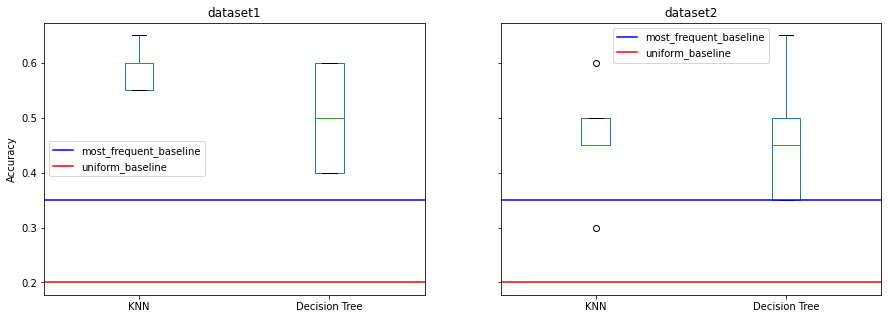

In [435]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"KNN": method_knn_quantiles_accuracy, 
          "Decision Tree": method_dtclassifier_quantiles_accuracy}
for i, method in enumerate(methods):
    data = {}
    y_quantiles = method_y_quantiles_train[method]
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    ax.axhline(y=accuracy_score(DummyClassifier(strategy="most_frequent").fit(x, y_quantiles).predict(y_quantiles), y_quantiles), color="b", label="most_frequent_baseline")
    ax.axhline(y=accuracy_score(DummyClassifier(strategy="uniform", random_state=4).fit(x, y_quantiles).predict(y_quantiles), y_quantiles), color="r", label="uniform_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="Accuracy")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/quantile_accuracy.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

<Figure size 1008x360 with 0 Axes>

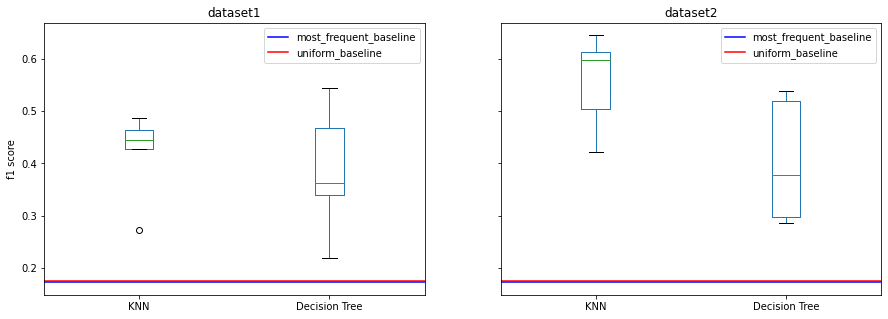

In [436]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"KNN": method_knn_quantiles_f1, 
          "Decision Tree": method_dtclassifier_quantiles_f1}
for i, method in enumerate(methods):
    data = {}
    y_quantiles = method_y_quantiles_train[method]
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    ax.axhline(y=f1_score(DummyClassifier(strategy="most_frequent").fit(x, y_quantiles).predict(y_quantiles), y_quantiles, average="macro"), color="b", label="most_frequent_baseline")
    ax.axhline(y=f1_score(DummyClassifier(strategy="uniform", random_state=4).fit(x, y_quantiles).predict(y_quantiles), y_quantiles, average="macro"), color="r", label="uniform_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="f1 score")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/quantile_f1.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

**Interpreting DT for method0**

<Figure size 1008x360 with 0 Axes>

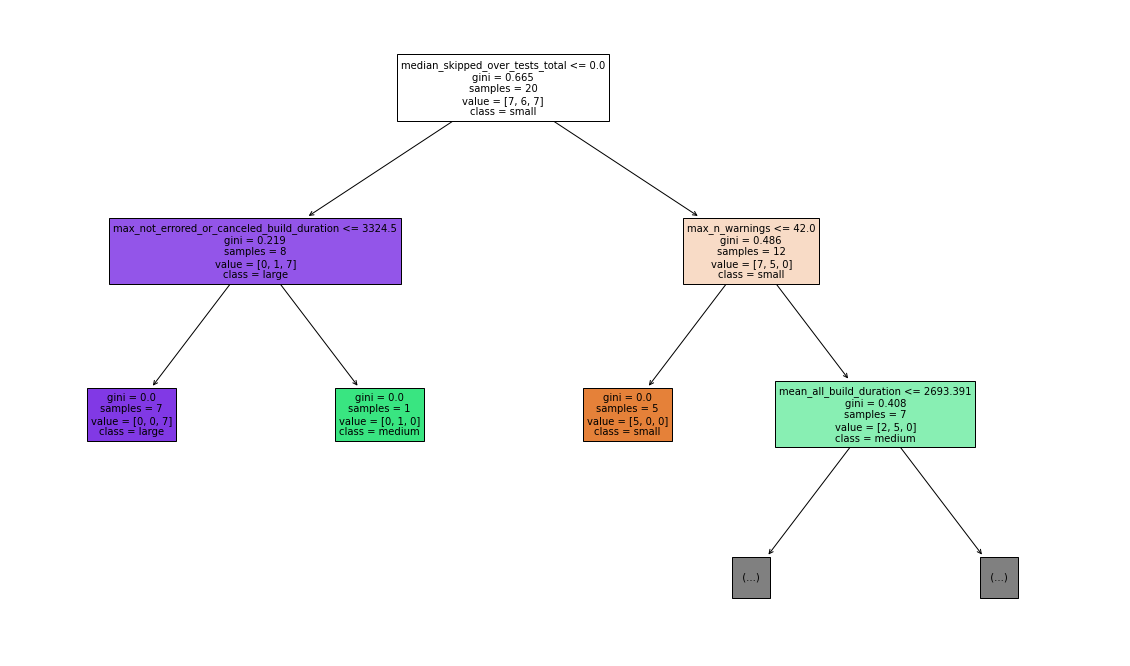

In [437]:
plt.figure()
from sklearn.tree import plot_tree
dt = DecisionTreeClassifier()
dt.fit(methods_indep_var[methods[0]], method_y_quantiles_train[methods[0]])
fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(dt, feature_names=method_x_train[methods[0]].columns, max_depth=2, filled=True, class_names=["small", "medium", "large"], fontsize=10)
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/dt_method0.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

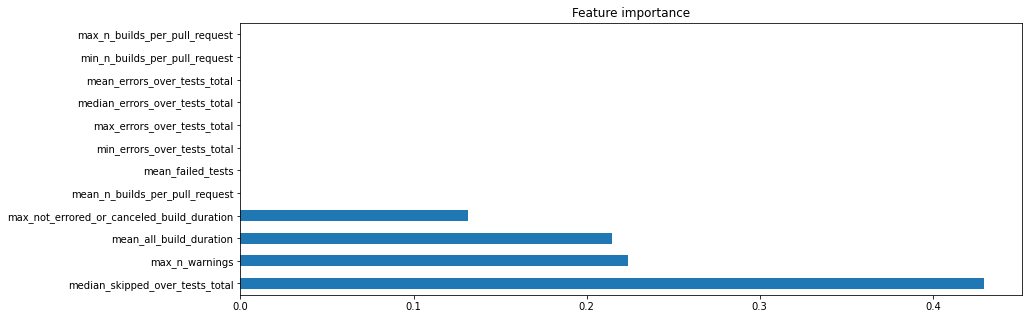

In [438]:
plt.figure()
ax = pd.Series(dt.feature_importances_, method_x_train[methods[0]].columns).sort_values(ascending=False).head(12).plot(kind="barh")
ax.set_title("Feature importance")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/dt_f_impo_method0.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

**Interpreting KNN for method1**

<ipython-input-439-ee34f9726604>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["classes"] = method_y_quantiles_train[m].map({0:"small", 1:"medium", 2:"large"})


<Figure size 1008x360 with 0 Axes>

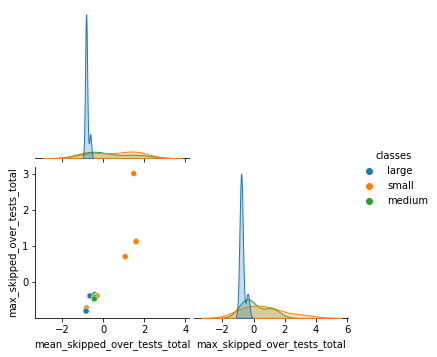

In [439]:
plt.figure()
m = methods[1]
df = method_x_train[m][method_knn_quantiles_features[m]]
df["classes"] = method_y_quantiles_train[m].map({0:"small", 1:"medium", 2:"large"})
"""sns.scatterplot(data=df, x="max_failed_build_duration", y="failed_gp3_bs3_burst_size_mean", marker="o",\
                hue="quantiles", palette="deep")"""
sns.pairplot(df, hue="classes",corner=True)
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/knn_method1_plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

### Binary

In [440]:
method_y_bin_train = {}
for method in methods:
    method_y_bin_train[method] = method_y_train[method] > method_y_train[method].median()

In [444]:
method_y_bin_train[method].sum()

9

In [445]:
method_y_train[method].median()

7.0

In [534]:
min_samples_leaf = [1,2,3,4]
max_depth = [3,4,5,None]
params_grid = {'min_samples_leaf': min_samples_leaf,
               "max_depth" : max_depth
              }

model = DecisionTreeClassifier()
method_randomclassifier_binary_f1 = {}
method_dtclassifier_binary_accuracy = {}
method_dtclassifier_binary_auc = {}
for method in methods:
    method_randomclassifier_binary_f1[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_bin_train[method], 5, 3, "f1")
    method_dtclassifier_binary_accuracy[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_bin_train[method], 5, 3, "accuracy")
    method_dtclassifier_binary_auc[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_bin_train[method], 5, 3, "roc_auc")

In [535]:
for method in methods:
    print(method, "Accuracy", method_dtclassifier_binary_accuracy[method], method_dtclassifier_binary_accuracy[method].mean())
    print(method, "F1", method_randomclassifier_binary_f1[method], method_randomclassifier_binary_f1[method].mean())
    print(method, method_dtclassifier_binary_auc[method])

dataset1 Accuracy [0.6031746  0.65873016 0.65079365 0.76190476 0.70634921] 0.6761904761904762
dataset1 F1 [0.35555556 0.71428571 0.45714286 0.52380952 0.44047619] 0.49825396825396834
dataset1 [0.45555556 0.825      0.68333333 0.68888889 0.58333333]
dataset2 Accuracy [0.5        0.5952381  0.65079365 0.70634921 0.5952381 ] 0.6095238095238096
dataset2 F1 [0.24444444 0.57936508 0.48888889 0.35714286 0.41269841] 0.41650793650793655
dataset2 [0.4        0.74166667 0.71111111 0.63888889 0.72916667]


In [542]:
method_knn_bin_features = {}
method_knn_bin_feature_performance = {}
for method in methods:
    features, score, feature_performance = forward_feature_selection(KNeighborsClassifier(), method_x_train[method],\
                                           method_y_bin_train[method], cv=cross_validation_strategy, scoring="f1")
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_knn_bin_features[method] = features
    method_knn_bin_feature_performance[method] = feature_performance

--------------------
dataset1 ['mean_skipped_over_tests_total'] 0.6666666666666666
--------------------
--------------------
dataset2 ['mean_skipped_over_tests_total'] 0.6666666666666666
--------------------


In [553]:
params_grid = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 4, num = 4)],
              'p': [1,2,3]}
model = KNeighborsClassifier()
method_knn_f1 = {}
method_knn_accuracy = {}
method_knn_auc = {}
for method in methods:
    x = method_x_train[method][method_knn_bin_features[method]]
    method_knn_f1[method] = \
            two_layer_cross_validate(model, params_grid,  x, method_y_bin_train[method], 5, 3, "f1")
    method_knn_accuracy[method] = \
            two_layer_cross_validate(model, params_grid, x, method_y_bin_train[method], 5, 3, "accuracy")
    method_knn_auc[method] = \
            two_layer_cross_validate(model, params_grid, x, method_y_bin_train[method], 5, 3, "roc_auc")


In [554]:
for method in methods:
    print(method, "Accuracy", method_knn_accuracy[method], method_knn_accuracy[method].mean())
    print(method, "F1", method_knn_f1[method], method_knn_f1[method].mean())
    print(method, method_knn_auc[method])

dataset1 Accuracy [0.58730159 0.71428571 0.75396825 0.75396825 0.6984127 ] 0.7015873015873015
dataset1 F1 [0.58730159 0.71428571 0.72222222 0.53571429 0.66269841] 0.6444444444444445
dataset1 [0.75555556 0.8        0.80555556 0.71944444 0.71666667]
dataset2 Accuracy [0.58730159 0.71428571 0.75396825 0.75396825 0.6984127 ] 0.7015873015873015
dataset2 F1 [0.58730159 0.71428571 0.72222222 0.53571429 0.66269841] 0.6444444444444445
dataset2 [0.75555556 0.8        0.80555556 0.71944444 0.71666667]


<Figure size 1008x360 with 0 Axes>

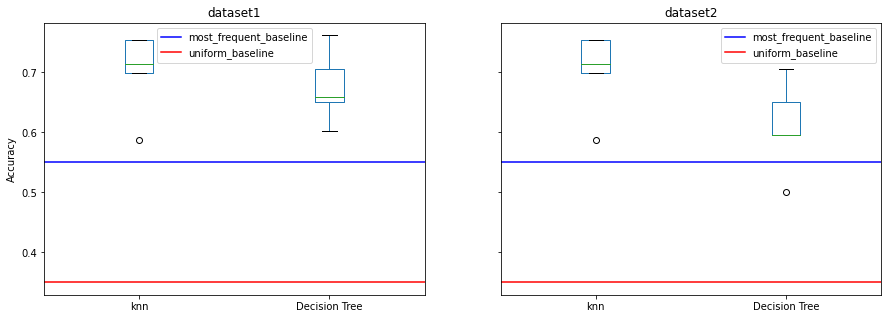

In [555]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"knn": method_knn_accuracy, 
          "Decision Tree": method_dtclassifier_binary_accuracy}
for i, method in enumerate(methods):
    data = {}
    y_bin = method_y_bin_train[method]
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    ax.axhline(y=accuracy_score(DummyClassifier(strategy="most_frequent").fit(x, y_bin).predict(y_bin), y_bin), color="b", label="most_frequent_baseline")
    ax.axhline(y=accuracy_score(DummyClassifier(strategy="uniform", random_state=4).fit(x, y_bin).predict(y_bin), y_bin), color="r", label="uniform_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="Accuracy")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/binary_accuracy.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

<Figure size 1008x360 with 0 Axes>

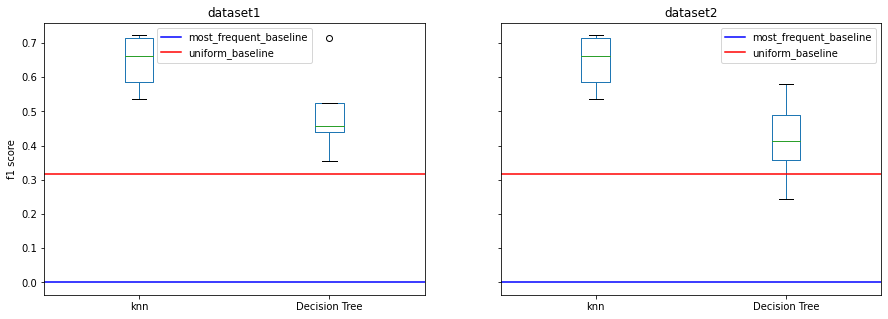

In [556]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"knn": method_knn_f1, 
          "Decision Tree": method_randomclassifier_binary_f1}
for i, method in enumerate(methods):
    data = {}
    y_bin = method_y_bin_train[method]
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    ax.axhline(y=f1_score(DummyClassifier(strategy="most_frequent").fit(x, y_bin).predict(y_bin), y_bin), color="b", label="most_frequent_baseline")
    ax.axhline(y=f1_score(DummyClassifier(strategy="uniform", random_state=4).fit(x, y_bin).predict(y_bin), y_bin), color="r", label="uniform_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="f1 score")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/binary_f1.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

<Figure size 1008x360 with 0 Axes>

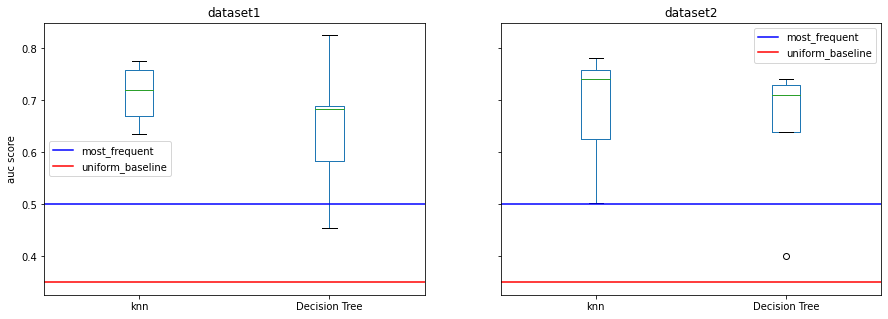

In [541]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"knn": method_knn_auc, 
          "Decision Tree": method_dtclassifier_binary_auc}
for i, method in enumerate(methods):
    data = {}
    y_bin = method_y_bin_train[method]
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    ax.axhline(y=0.5, color="b", label="most_frequent")
    ax.axhline(y=roc_auc_score(DummyClassifier(strategy="uniform", random_state=4).fit(x, y_bin).predict(y_bin), y_bin), color="r", label="uniform_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="auc score")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/binary_auc.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

In [ ]:
for i, method in enumerate([methods[0]]):
    plt.figure()
    df = method_x_train[method][method_knn_bin_features[method]]
    #if i == 0:
        #df = df[(df.max_all_build_duration < 0.00) & (df.max_n_builds_per_pull_request < 5)]
    #if i == 1:
        #df = df[(df.mean_failed_tests < 0.05) & (df.max_n_builds_per_pull_request < 1)]
    df["classes"] = method_y_bin_train[method].map({True:"large", False:"small"})
    """sns.scatterplot(data=df, x="max_failed_build_duration", y="failed_gp3_bs3_burst_size_mean", marker="o",\
                    hue="quantiles", palette="deep")"""
    sns.pairplot(df, hue="classes",corner=True)
    plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/knn_{method}_bin_plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

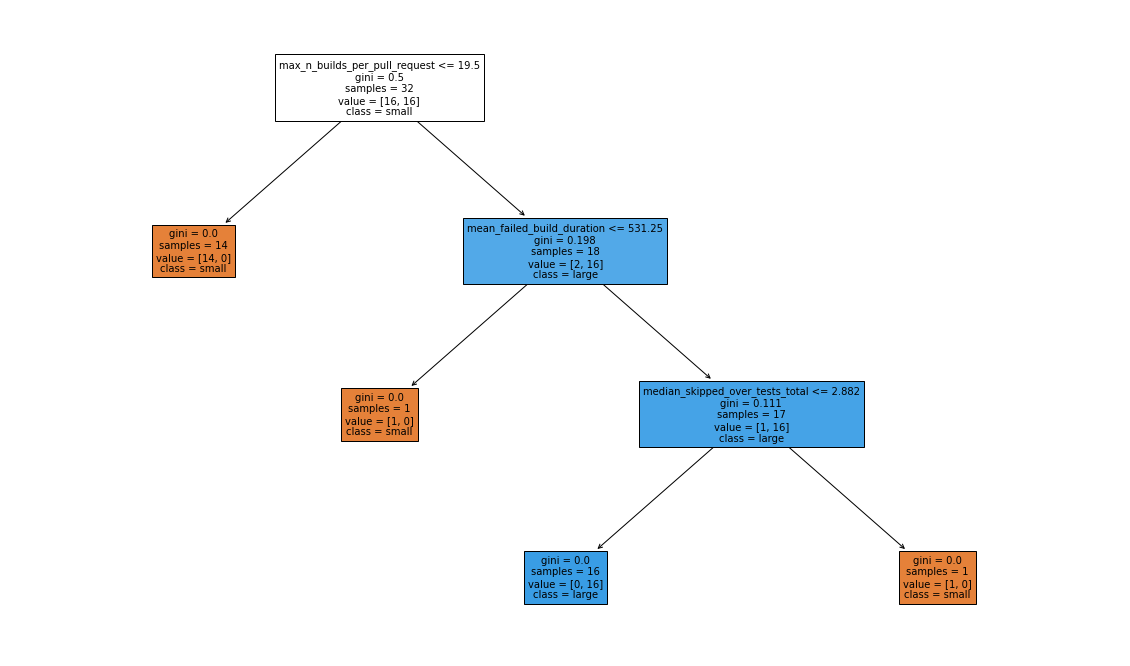

In [361]:
from sklearn.tree import plot_tree
dt = DecisionTreeClassifier()
dt.fit(methods_indep_var[methods[1]], method_y_bin_train[methods[1]])
fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(dt, feature_names=method_x_train[methods[1]].columns, filled=True, class_names=["small", "large"], fontsize=10)
plt.show()

In [573]:
methods_dep_var[method]

,java_build_tool,post_release_bugs,fix_time,dde,critical_post_release_bugs,minor_post_release_bugs
32,gradle,18.0,25.708642,0.100000,0.0,1.0
33,gradle,22.0,14.649190,0.043478,0.0,1.0
34,gradle,18.0,20.733183,0.052632,1.0,1.0
35,gradle,5.0,5.807028,0.166667,0.0,1.0
36,gradle,10.0,67.390606,0.000000,1.0,3.0
37,gradle,16.0,29.200757,0.058824,0.0,3.0
38,gradle,7.0,23.364011,0.300000,1.0,2.0
39,gradle,18.0,55.368771,0.052632,2.0,1.0
40,gradle,23.0,40.314666,0.000000,0.0,9.0
41,gradle,6.0,14.085432,0.250000,0.0,0.0


In [587]:
df

,mean_skipped_over_tests_total,classes
32,-0.832427,large
33,-0.832428,large
34,-0.832430,large
35,-0.814095,small
36,-0.832423,large
37,-0.832439,large
38,-0.663098,small
39,-0.634190,large
40,-0.832468,large
41,-0.408870,small


<ipython-input-600-e0872616672a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["classes"] = method_y_bin_train[m].map({False:"small", True:"large"})
<ipython-input-600-e0872616672a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[""] = ""
<ipython-input-600-e0872616672a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

<Figure size 1008x360 with 0 Axes>

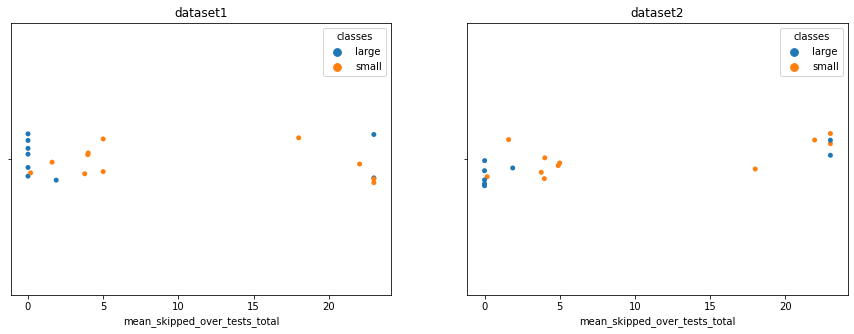

In [600]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15.0, 5.0))
for i, method in enumerate(methods):
    df = methods_indep_var[method][method_knn_bin_features[method]]
    y = methods_dep_var[method].post_release_bugs
    df["classes"] = method_y_bin_train[m].map({False:"small", True:"large"})
    df[""] = ""
    ax = sns.stripplot(x="mean_skipped_over_tests_total",\
                         y="",hue="classes", data=df, ax=axes[i])
    ax.set_title(method)
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/knn_binary_plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

<ipython-input-557-23664331dd51>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["classes"] = method_y_bin_train[m].map({False:"small", True:"large"})


<Figure size 1008x360 with 0 Axes>

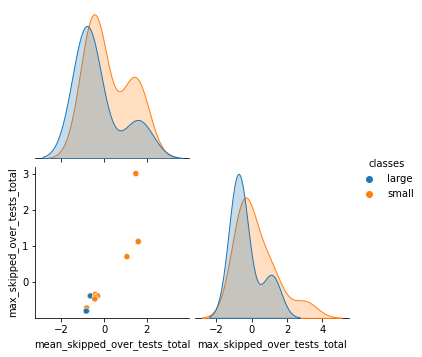

In [557]:
plt.figure()
m = methods[1]
df = method_x_train[m][method_knn_quantiles_features[m]]
df["classes"] = method_y_bin_train[m].map({False:"small", True:"large"})
"""sns.scatterplot(data=df, x="max_failed_build_duration", y="failed_gp3_bs3_burst_size_mean", marker="o",\
                hue="quantiles", palette="deep")"""
sns.pairplot(df, hue="classes",corner=True)
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/knn_method1_plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

**----------------------------------------**

### PCA

In [382]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
X = methods_indep_var[methods[1]][mask]
X = StandardScaler().fit_transform(X)
y = methods_dep_var[methods[1]][mask].java_build_tool.reset_index(drop=True)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

In [383]:
finalDf = pd.concat([principalDf, y], axis = 1)

In [392]:
pca.explained_variance_ratio_[:1].sum()

0.23559056005146486

<AxesSubplot:>

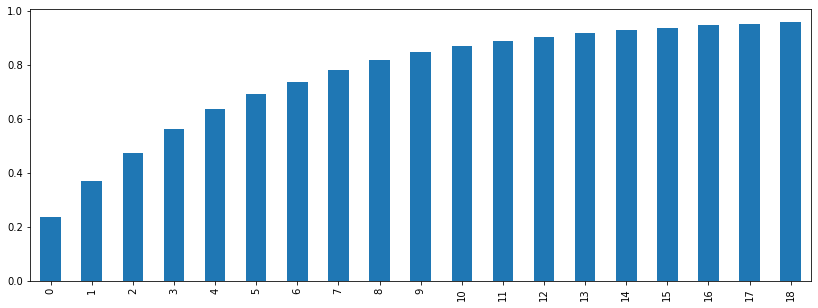

In [402]:
data = []
for i in range(1, len(pca.explained_variance_ratio_)):
    data.append((i, pca.explained_variance_ratio_[:i].sum()))
pd.DataFrame(data)[1].plot(kind="bar")

In [346]:
X_pca = pca.transform(X)

In [404]:
y_bugs = methods_dep_var[methods[1]].post_release_bugs

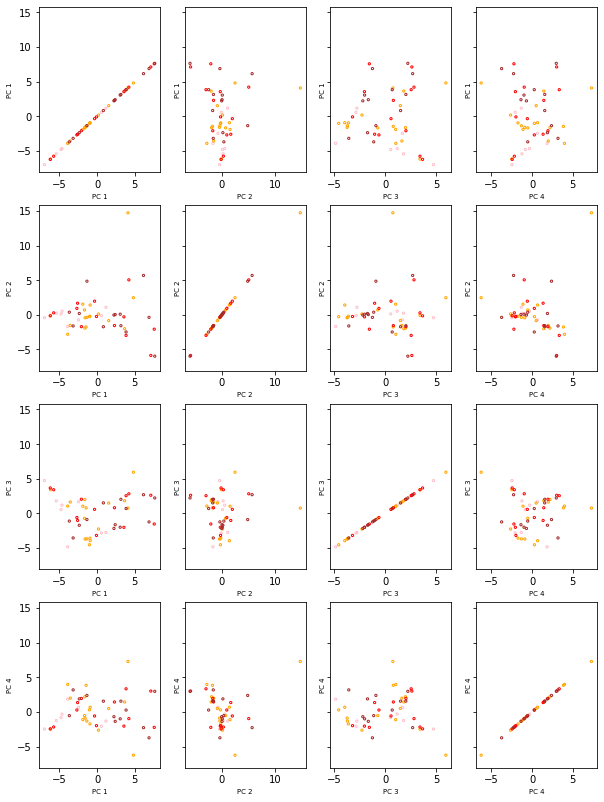

In [409]:
#plt.scatter(X_pca, y)
n_components = 4
fig, axes = plt.subplots(nrows=n_components, ncols=n_components, sharey=True, figsize=(10.0, 14.0))
for i in range(0,n_components):
    for j in range(0,n_components):
        ax = axes[i][j]
        ax.set_xlabel(f"PC {j+1}", fontsize = 7)
        ax.set_ylabel(f"PC {i+1}", fontsize = 7)
        colors = ["pink",'orange','red','brown','black']
        ranges = [(0,y_bugs.quantile(0.25)),(y_bugs.quantile(0.25),y_bugs.quantile(0.5))\
                  ,(y_bugs.quantile(0.5),y_bugs.quantile(0.75)), (y_bugs.quantile(0.75),y_bugs.quantile(1))]
        for rang, color in zip(ranges, colors):
            indicesToKeep = (y_bugs>=rang[0]) & (y_bugs<rang[1])
            ax.scatter(finalDf.loc[indicesToKeep, j],
                       finalDf.loc[indicesToKeep, i],
                       s = 5,
                       facecolors='none',
                       edgecolors=color)

In [421]:
df = pd.DataFrame(X)
df.columns = df.columns.astype(str)

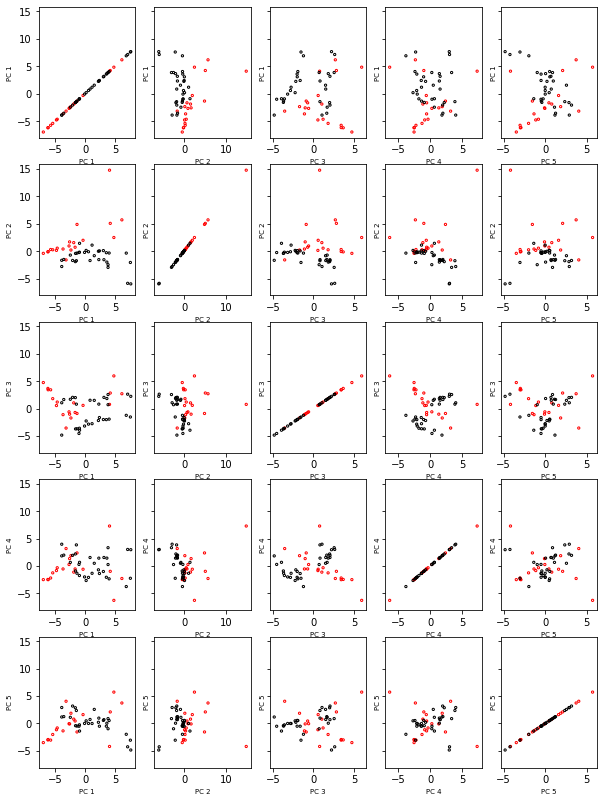

In [381]:
#plt.scatter(X_pca, y)
fig, axes = plt.subplots(nrows=5, ncols=5, sharey=True, figsize=(10.0, 14.0))
for i in range(0,5):
    for j in range(0,5):
        ax = axes[i][j]
        ax.set_xlabel(f"PC {j+1}", fontsize = 7)
        ax.set_ylabel(f"PC {i+1}", fontsize = 7)
        colors = ['r','black']
        ranges = ["gradle", "maven"]
        for rang, color in zip(ranges, colors):
            indicesToKeep = (y==rang)
            ax.scatter(finalDf.loc[indicesToKeep, j],
                       finalDf.loc[indicesToKeep, i],
                       s = 5,
                       facecolors='none',
                       edgecolors=color)